In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.optimizer import LinearClassifierOptimizer

SKY_WHITE_SCARF = '#11eeff'
BLOOD = '#ff8080'  # &
YELLOW_SEND = '#FFFF00'
CRY_OF_DESPAIR = '#8900FF'

MINT = '#04FF82'

Since on the DA course I didn't use datasets that are good for the binary classification, I decided not to 'invent the bycycle' with previous datasets and just take it from _kaage_. Purpose - define edible mushroom or not and respectively the target feature is column named 'edible'

*here is single-time cut of shuffled data for purposes of time reducing and make results stable(shuffle only 1 time and further data is immutable in correspond csv-file)*
_(You can see that in original dataset about 20k items, but SVM had worked ~7 hr even on 5k items, so it was decided to limit data of 1,5k)_

In [58]:
#df = pd.read_csv('data/mushroom_cleaned.csv')
#df = df.sample(frac=1)[:1500]
#df.to_csv('data/prepared_mushroom.csv', index=False)

In [59]:
df = pd.read_csv('data/prepared_mushroom.csv')
df.head(10)

cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0           973          6                0          10     2.581938   
1           413          2                1           6     0.585337   
2          1605          5                1          10     1.069922   
3           466          2                6          11     0.438114   
4           545          2                1          10     0.139690   
5           304          5                0           9     0.159585   
6           879          2                6          10     1.790119   
7            38          6                0          11     0.963341   
8          1568          6                2          10     1.873678   
9           511          5                1           6     0.051301   

   stem-width  stem-color    season  edible  
0        2215          11  0.888450       0  
1        1027          11  0.943195       0  
2        2538          11  1.804273       0  
3         492          12  0.943195       1  
4        1071           6  0.943195       1  
5         501          10  0.888450       1  
6        1142          11  0.888450       1  
7          25          11  0.943195       1  
8        1846          11  0.888450       0  
9        1296          11  0.943195       0

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cap-diameter     1500 non-null   int64  
 1   cap-shape        1500 non-null   int64  
 2   gill-attachment  1500 non-null   int64  
 3   gill-color       1500 non-null   int64  
 4   stem-height      1500 non-null   float64
 5   stem-width       1500 non-null   int64  
 6   stem-color       1500 non-null   int64  
 7   season           1500 non-null   float64
 8   edible           1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB


In [61]:
for df_key in df.keys():
    print(f'{df_key}: {df[df_key].describe()}; unique values: {df[df_key].nunique()}')

cap-diameter: count    1500.000000
mean      514.074000
std       341.795958
min         1.000000
25%       254.000000
50%       475.000000
75%       712.250000
max      1753.000000
Name: cap-diameter, dtype: float64; unique values: 829
cap-shape: count    1500.000000
mean        3.836000
std         2.281353
min         0.000000
25%         2.000000
50%         5.000000
75%         6.000000
max         6.000000
Name: cap-shape, dtype: float64; unique values: 6
gill-attachment: count    1500.00000
mean        2.05200
std         2.24811
min         0.00000
25%         0.00000
50%         1.00000
75%         5.00000
max         6.00000
Name: gill-attachment, dtype: float64; unique values: 5
gill-color: count    1500.000000
mean        8.483333
std         2.774681
min         0.000000
25%         7.000000
50%        10.000000
75%        10.000000
max        11.000000
Name: gill-color, dtype: float64; unique values: 11
stem-height: count    1500.000000
mean        0.759522
std         0.

In this dataset all features already continuous, so that's left only to normalize data

In [62]:
def normalize(data):
    for df_key in data.keys():
        min_v = np.min(data[df_key])
        max_v = np.max(data[df_key])
        data[df_key] = (data[df_key] - min_v) / (max_v - min_v)
    print('data was normalized')

In [63]:
normalize(df)
df.head()

data was normalized


cap-diameter  cap-shape  gill-attachment  gill-color  stem-height  \
0      0.554795   1.000000         0.000000    0.909091     0.684989   
1      0.235160   0.333333         0.166667    0.545455     0.154560   
2      0.915525   0.833333         0.166667    0.909091     0.283298   
3      0.265411   0.333333         1.000000    1.000000     0.115448   
4      0.310502   0.333333         0.166667    0.909091     0.036167   

   stem-width  stem-color    season  edible  
0    0.642298    0.916667  0.484596     0.0  
1    0.297650    0.916667  0.515404     0.0  
2    0.736002    0.916667  1.000000     0.0  
3    0.142443    1.000000  0.515404     1.0  
4    0.310415    0.500000  0.515404     1.0

*Note that normalization doesn't affect on target feature*

In [64]:
df['edible'].describe()

count    1500.000000
mean        0.460000
std         0.498564
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: edible, dtype: float64

Here are the helper functions to handle the best parameters for each type of model correctly, because optuna's categorical param doesn't support Object values, but in my implementations custom objects for such parameters as _empirical risk_ or _kernel_ are used. Also, since in data frame initially were values of `{0, 1}` that were mapped for classifiers to `{-1, 1}`, here is inverse function that map `{-1, 1}` to `{0, 1}`

In [65]:
from model.interactor.abstract_interactor import KlassifierInteractorABC
from typing import Dict, Any, Type, TypeVar, Callable


def fix_kernel_param(best_params: Dict[str, Any]) -> Dict[str, Any]:
    if 'kernel' in best_params:
        print('kernel')
        if best_params['kernel'] == KType.POLYNOMIAL:
            deg = best_params['degree']
            best_params.__delitem__('degree')
            best_params['kernel'] = PolynomialKernel(deg)
        elif best_params['kernel'] == KType.GAUSSIAN:
            if 'gamma' not in best_params:
                print('123')
            gamma = best_params['gamma']
            best_params.__delitem__('gamma')
            best_params.__setitem__('kernel', GaussianKernel(gamma))
        else:
            best_params.__setitem__('kernel', LinearKernel())

        return best_params


def fix_loss_func_param(best_params: Dict[str, Any]) -> Dict[str, Any]:
    if 'loss_function' in best_params:
        lf = LOSS_FUNCTION_MAPPING.get(best_params['loss_function'])()
        best_params.__setitem__('loss_function', lf)
    return best_params


T = TypeVar('T', bound=KlassifierInteractorABC)


def override_best_params(type_token: Type[T], fix_param_function: Callable[[Dict[str, Any]], Dict[str, Any]]):
    if type_token not in optimizer.modes:
        raise ValueError('Illegal interactor type. Expected existing instance')
    cur_tuple = optimizer.modes[type_token]
    print(cur_tuple)
    optimizer.add_mode(type_token, cur_tuple[0], fix_param_function(cur_tuple[1]))


def default_transformer(x):
    return np.where(x > 0, 1, 0)

Initialize optimizer firstly with my implementations only

In [66]:
from model.interactor.impl.ridge_interactor import RidgeRegressionInteractor
from model.interactor.impl.gd_interactor import GradientDescentInteractor
from model.interactor.impl.svm_interactor import SVMInteractor

df['edible_mapped'] = np.where(df['edible'] == 0, -1, 1)

exdog = df.drop(['edible', 'edible_mapped'], axis=1)
endog = df['edible_mapped'].copy()
optimizer = LinearClassifierOptimizer(exdog, endog, df['edible'], test_part=0.25)

optimizer.add_mode(RidgeRegressionInteractor, RidgeRegressionInteractor())
optimizer.add_mode(GradientDescentInteractor, GradientDescentInteractor())
optimizer.add_mode(SVMInteractor, SVMInteractor())

 [INFO] LinearClassifierOptimizer 2024-05-23 00:38:20.070995: RidgeRegressionInteractor(<class 'model.interactor.impl.ridge_interactor.RidgeRegressionInteractor'>) successfully added(updated)
 [INFO] LinearClassifierOptimizer 2024-05-23 00:38:20.070995: GradientDescentInteractor(<class 'model.interactor.impl.gd_interactor.GradientDescentInteractor'>) successfully added(updated)
 [INFO] LinearClassifierOptimizer 2024-05-23 00:38:20.071996: SVMInteractor(<class 'model.interactor.impl.svm_interactor.SVMInteractor'>) successfully added(updated)


Bellow following 3 blocks of actions with each of models: `RidgeRegression`, `GradientDescent`, `SVM`. First, just 'check compatibility' with nearly random parameters and then, be sure that model basically work, find its best parameters

In [67]:
optimizer.switch_mode(RidgeRegressionInteractor)
ridge_regression = optimizer.current_interactor.build({'alpha': 100})
ridge_regression.fit(optimizer.train_exdog, optimizer.train_ans)
preds = ridge_regression.predict(optimizer.test_exdog)
#for p in np.array(preds - optimizer.test_real_ans):
#    print(np.array(p), end=' ')
print("\n")
print(f'f1_score: {optimizer.metric(optimizer.test_real_ans, preds)}')



f1_score: 0.5770491803278689


In [68]:
best_ridge_param = optimizer.run_study()
best_ridge_param

[I 2024-05-23 00:38:20,254] A new study created in memory with name: no-name-082f4f0a-9d97-49f6-ba13-e05d79fbd75b
[I 2024-05-23 00:38:20,258] Trial 0 finished with value: 0.0 and parameters: {'alpha': 5681.605016066127}. Best is trial 0 with value: 0.0.
[I 2024-05-23 00:38:20,261] Trial 1 finished with value: 0.5241379310344828 and parameters: {'alpha': 137.46689982512385}. Best is trial 1 with value: 0.5241379310344828.
[I 2024-05-23 00:38:20,265] Trial 2 finished with value: 0.0 and parameters: {'alpha': 1551.1501909263682}. Best is trial 1 with value: 0.5241379310344828.
[I 2024-05-23 00:38:20,270] Trial 3 finished with value: 0.0 and parameters: {'alpha': 790.051472755785}. Best is trial 1 with value: 0.5241379310344828.
[I 2024-05-23 00:38:20,273] Trial 4 finished with value: 0.0 and parameters: {'alpha': 4904.300917227982}. Best is trial 1 with value: 0.5241379310344828.
[I 2024-05-23 00:38:20,277] Trial 5 finished with value: 0.0 and parameters: {'alpha': 9540.149367489075}. Bes

 [INFO] LinearClassifierOptimizer 2024-05-23 00:38:30.485208: <class 'model.interactor.impl.ridge_interactor.RidgeRegressionInteractor'> best trial finished with value 0.6470588235294118; best params {'alpha': 9.991381071285872}


FrozenTrial(number=81, state=1, values=[0.6470588235294118], datetime_start=datetime.datetime(2024, 5, 23, 0, 38, 20, 854233), datetime_complete=datetime.datetime(2024, 5, 23, 0, 38, 20, 861234), params={'alpha': 9.991381071285872}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=10000.0, log=False, low=0.0, step=None)}, trial_id=81, value=None)

 [WARN] GradientDescentClassifier 2024-05-23 00:38:30.494833: Loss function is not defined, used default for this instance FunType.HINGE


f1_score: 0.64376130198915


Text(0.5, 1.0, 'Gradient Descent')

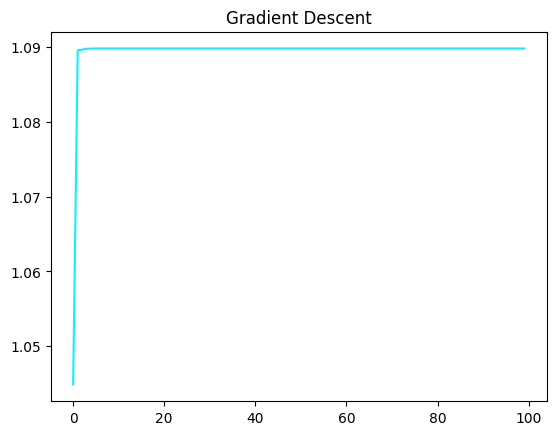

In [69]:
from model.params.loss_function import *

optimizer.switch_mode(GradientDescentInteractor)
grad_descent = optimizer.current_interactor.build({'alpha': 0.1, 'beta': 0.8, 'num_iters': 100,
                                                   'learning_rate': 0.03, 'loss_function': HingeLoss()})
errs = grad_descent.fit(optimizer.train_exdog, optimizer.train_ans)
preds = grad_descent.predict(optimizer.test_exdog)
print("\n")
print(f'f1_score: {optimizer.metric(optimizer.test_real_ans, preds)}')
plt.plot(list(range(len(errs))), errs, c=SKY_WHITE_SCARF)
plt.title("Gradient Descent")

In [70]:
best_gd_param = optimizer.run_study(n_trials=200)
override_best_params(GradientDescentInteractor, fix_loss_func_param)

[I 2024-05-23 00:38:30,705] A new study created in memory with name: no-name-7ceadd54-5e81-44b5-8974-23e97968abb3
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a

 [WARN] GradientDescentClassifier 2024-05-23 00:38:30.707318: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:30.810319: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:31,381] Trial 1 finished with value: 0.0 and parameters: {'alpha': 776.6986750980558, 'beta': 670.8836274984138, 'learning_rate': 0.058757896571160824, 'num_iters': 588, 'loss_function': 'hinge'}. Best is trial 0 with value: 0.0.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))


 [WARN] GradientDescentClassifier 2024-05-23 00:38:31.383321: Loss function is not defined, used default for this instance mse


[I 2024-05-23 00:38:31,902] Trial 2 finished with value: 0.0 and parameters: {'alpha': 956.7441070526326, 'beta': 838.029606184919, 'learning_rate': 0.07559796463970102, 'num_iters': 754, 'loss_function': 'squared_error'}. Best is trial 0 with value: 0.0.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:32,095] Trial 3 finished with value: 0.0 and parameters: {'alpha': 686.1347203888911, 'beta': 490.10771855627723, 'learning_rate': 0.06481923284904048, 'num_iters': 280, 'loss_function': 'squared_error'}. Best is trial 0 with value: 0.0.


 [WARN] GradientDescentClassifier 2024-05-23 00:38:31.904901: Loss function is not defined, used default for this instance mse


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:32.096062: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:32.181880: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:32.674149: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:32.766603: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:32.870603: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:33.196869: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:33,542] Trial 9 finished with value: 0.0 and parameters: {'alpha': 347.74107660147666, 'beta': 715.0810644750705, 'learning_rate': 0.03197670644901156, 'num_iters': 651, 'loss_function': 'log_loss'}. Best is trial 6 with value: 0.6628895184135978.


 [WARN] GradientDescentClassifier 2024-05-23 00:38:33.566624: Loss function is not defined, used default for this instance FunType.HINGE


[I 2024-05-23 00:38:33,864] Trial 10 finished with value: 0.64376130198915 and parameters: {'alpha': 40.81161342599995, 'beta': 984.5177352999478, 'learning_rate': 0.004720466858827991, 'num_iters': 348, 'loss_function': 'hinge'}. Best is trial 6 with value: 0.6628895184135978.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\l

 [WARN] GradientDescentClassifier 2024-05-23 00:38:33.883051: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:34.159650: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:34.187649: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:34.479624: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:35,049] Trial 14 finished with value: 0.0 and parameters: {'alpha': 464.1436532746708, 'beta': 196.7723566552167, 'learning_rate': 0.019942155716958614, 'num_iters': 807, 'loss_function': 'hinge'}. Best is trial 6 with value: 0.6628895184135978.


 [WARN] GradientDescentClassifier 2024-05-23 00:38:35.066753: Loss function is not defined, used default for this instance mse


[I 2024-05-23 00:38:35,420] Trial 15 finished with value: 0.64376130198915 and parameters: {'alpha': 205.45381956442907, 'beta': 131.43250434375716, 'learning_rate': 0.007373793465399368, 'num_iters': 507, 'loss_function': 'squared_error'}. Best is trial 6 with value: 0.6628895184135978.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn

 [WARN] GradientDescentClassifier 2024-05-23 00:38:35.436140: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:35.612750: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:35.656748: Loss function is not defined, used default for this instance mse


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:35,948] Trial 18 finished with value: 0.0 and parameters: {'alpha': 239.71707984459744, 'beta': 850.0176861375468, 'learning_rate': 0.013569998801260712, 'num_iters': 434, 'loss_function': 'squared_error'}. Best is trial 6 with value: 0.6628895184135978.


 [WARN] GradientDescentClassifier 2024-05-23 00:38:35.965412: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:36,387] Trial 19 finished with value: 0.0 and parameters: {'alpha': 452.1354854647868, 'beta': 567.7068726388861, 'learning_rate': 0.02746740479592161, 'num_iters': 600, 'loss_function': 'hinge'}. Best is trial 6 with value: 0.6628895184135978.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: 

 [WARN] GradientDescentClassifier 2024-05-23 00:38:36.405212: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:36,754] Trial 20 finished with value: 0.0 and parameters: {'alpha': 824.5109920459522, 'beta': 236.27022415705477, 'learning_rate': 0.05434053577632994, 'num_iters': 712, 'loss_function': 'log_loss'}. Best is trial 6 with value: 0.6628895184135978.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear

 [WARN] GradientDescentClassifier 2024-05-23 00:38:36.772425: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:36.817022: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:36.965672: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.034673: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.183130: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.445729: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.548625: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.850132: Loss function is not defined, used default for this instance mse
 [WARN] GradientDescentClassifier 2024-05-23 00:38:37.937096: Loss function is not defined, used default for this instance FunType.HINGE


[I 2024-05-23 00:38:38,089] Trial 29 finished with value: 0.64376130198915 and parameters: {'alpha': 384.16744947666103, 'beta': 265.85186432004696, 'learning_rate': 0.03609326577532657, 'num_iters': 187, 'loss_function': 'hinge'}. Best is trial 21 with value: 0.6783625730994152.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML

 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.109100: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:38,596] Trial 30 finished with value: 0.0 and parameters: {'alpha': 123.8059385261335, 'beta': 95.02680098083894, 'learning_rate': 0.08925363151983376, 'num_iters': 869, 'loss_function': 'log_loss'}. Best is trial 21 with value: 0.6783625730994152.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear

 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.617403: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.650406: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.751742: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.783738: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.814775: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:38.882332: Loss function is not defined, used default for this instance mse
 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.080038: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.212332: Loss function is not defined, used default for this instance FunType.HINGE
 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.337985: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.379991: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.458586: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.853160: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:39.989787: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:40.259047: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:40.457687: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:40.593309: Loss function is not defined, used default for this instance mse
 [WARN] GradientDescentClassifier 2024-05-23 00:38:40.646345: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:40.927603: Loss function is not defined, used default for this instance FunType.HINGE


[I 2024-05-23 00:38:41,142] Trial 48 finished with value: 0.64376130198915 and parameters: {'alpha': 9.692966408877282, 'beta': 126.22377954345424, 'learning_rate': 0.005057041576093211, 'num_iters': 255, 'loss_function': 'hinge'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML

 [WARN] GradientDescentClassifier 2024-05-23 00:38:41.164758: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:41.395377: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:41,732] Trial 50 finished with value: 0.0 and parameters: {'alpha': 692.3315667107256, 'beta': 297.6924736722779, 'learning_rate': 0.08479782564775988, 'num_iters': 655, 'loss_function': 'log_loss'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear

 [WARN] GradientDescentClassifier 2024-05-23 00:38:41.754721: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:42.032997: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:42.361945: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:42.698446: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:43.051687: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:43.103688: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:43.391333: Loss function is not defined, used default for this instance mse


[I 2024-05-23 00:38:43,878] Trial 57 finished with value: 0.64376130198915 and parameters: {'alpha': 305.576670322509, 'beta': 221.15789522229448, 'learning_rate': 0.00362997290809418, 'num_iters': 695, 'loss_function': 'squared_error'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a

 [WARN] GradientDescentClassifier 2024-05-23 00:38:43.899290: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:43.981290: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:44,303] Trial 59 finished with value: 0.0 and parameters: {'alpha': 359.44537764394124, 'beta': 181.62757537257284, 'learning_rate': 0.04692510069254492, 'num_iters': 434, 'loss_function': 'hinge'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarnin

 [WARN] GradientDescentClassifier 2024-05-23 00:38:44.325279: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:44,595] Trial 60 finished with value: 0.0 and parameters: {'alpha': 418.2500881182317, 'beta': 696.7532170118933, 'learning_rate': 0.0568644654165943, 'num_iters': 547, 'loss_function': 'log_loss'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + n

 [WARN] GradientDescentClassifier 2024-05-23 00:38:44.616999: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:44.953924: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:45.346211: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:45.826167: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:46.277301: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:47.049219: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:47.936453: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:49.343388: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:50.603104: Loss function is not defined, used default for this instance mse


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:52,341] Trial 69 finished with value: 0.0 and parameters: {'alpha': 288.5732151917988, 'beta': 35.910492066506215, 'learning_rate': 0.09565658916842738, 'num_iters': 956, 'loss_function': 'squared_error'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 /

 [WARN] GradientDescentClassifier 2024-05-23 00:38:52.377808: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:52.512510: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:52.576151: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:52.665183: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:53.151005: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:53.801862: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:54.365212: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:21: RuntimeWarning: overflow encountered in multiply
  grad -= (self.beta * self.weights + self.alpha * np.sign(self.weights))
[I 2024-05-23 00:38:55,083] Trial 76 finished with value: 0.0 and parameters: {'alpha': 181.1237012316127, 'beta': 136.57764847880912, 'learning_rate': 0.09168050002468824, 'num_iters': 747, 'loss_function': 'hinge'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning

 [WARN] GradientDescentClassifier 2024-05-23 00:38:55.122073: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:55.525215: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:56.030445: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:56.070930: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:56.194891: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:56.567230: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:56.927516: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:57.159557: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:57.515856: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:57,836] Trial 85 finished with value: 0.0 and parameters: {'alpha': 453.53605108752913, 'beta': 945.0742857102306, 'learning_rate': 0.08438378343931974, 'num_iters': 616, 'loss_function': 'log_loss'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linea

 [WARN] GradientDescentClassifier 2024-05-23 00:38:57.864457: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:38:58,122] Trial 86 finished with value: 0.0 and parameters: {'alpha': 236.51437230810706, 'beta': 506.8060560458937, 'learning_rate': 0.01488037990414293, 'num_iters': 498, 'loss_function': 'log_loss'}. Best is trial 33 with value: 0.6814516129032258.


 [WARN] GradientDescentClassifier 2024-05-23 00:38:58.149599: Loss function is not defined, used default for this instance mse


[I 2024-05-23 00:38:58,435] Trial 87 finished with value: 0.64376130198915 and parameters: {'alpha': 327.70677391565977, 'beta': 115.23275643295003, 'learning_rate': 0.021120238321590414, 'num_iters': 373, 'loss_function': 'squared_error'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_y

 [WARN] GradientDescentClassifier 2024-05-23 00:38:58.466016: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:58.594274: Loss function is not defined, used default for this instance FunType.HINGE


[I 2024-05-23 00:38:58,776] Trial 89 finished with value: 0.64376130198915 and parameters: {'alpha': 525.7645344215338, 'beta': 168.35027750906016, 'learning_rate': 0.0893708183795218, 'num_iters': 205, 'loss_function': 'hinge'}. Best is trial 33 with value: 0.6814516129032258.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\l

 [WARN] GradientDescentClassifier 2024-05-23 00:38:58.807986: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.021312: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.102834: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.227868: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.441056: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.525074: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.618147: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.704140: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.801413: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.869783: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:38:59.988046: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.039581: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.090581: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.131817: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.177776: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.227805: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.275815: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.327337: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.365339: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:39:00,491] Trial 109 finished with value: 0.64376130198915 and parameters: {'alpha': 513.5723776921315, 'beta': 360.3366756780463, 'learning_rate': 0.014087468938018266, 'num_iters': 57, 'loss_function': 'squared_error'}. Best is trial 100 with value: 0.694560669456067.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_

 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.446377: Loss function is not defined, used default for this instance mse
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.518338: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.557049: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.635017: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.692014: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.772387: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.824384: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:00.913385: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.016011: Loss function is not defined, used default for this instance FunType.HINGE


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.133016: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.232675: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.311646: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.388333: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.455334: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.588006: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.677999: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.753001: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.853603: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:01.972179: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.158209: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.317912: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.433561: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.472524: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.582169: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.686352: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.792353: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:02.944967: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.048661: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.171662: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.316247: Loss function is not defined, used default for this instance mse
 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.434862: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.548858: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.629524: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.786690: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:03.922593: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.096244: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.197432: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:39:04,426] Trial 146 finished with value: 0.64376130198915 and parameters: {'alpha': 443.65791904895286, 'beta': 644.5319935143395, 'learning_rate': 0.0007503791449584851, 'num_iters': 132, 'loss_function': 'hinge'}. Best is trial 100 with value: 0.694560669456067.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_

 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.321585: Loss function is not defined, used default for this instance FunType.HINGE
 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.456294: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.525292: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.672654: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.723607: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.809645: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:04.900202: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.013239: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.076822: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.154860: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.253643: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.317321: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.407287: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.531882: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.655034: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.790694: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.899322: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:05.973117: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.052548: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.117258: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.205224: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.289259: Loss function is not defined, used default for this instance mse


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.329909: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.395960: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.451939: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.607585: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.777163: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:06.944791: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.131088: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.331083: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.509496: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.668034: Loss function is not defined, used default for this instance FunType.HINGE
 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.734065: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:07.888096: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.014772: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.097809: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.177811: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.273936: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.355199: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.587064: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.778422: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.858424: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.912422: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:08.968426: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.171697: Loss function is not defined, used default for this instance binary_cross_entropy


[I 2024-05-23 00:39:09,371] Trial 190 finished with value: 0.0 and parameters: {'alpha': 435.26888363643235, 'beta': 455.98337124495225, 'learning_rate': 0.05255315658739882, 'num_iters': 294, 'loss_function': 'log_loss'}. Best is trial 153 with value: 0.6976744186046512.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-li

 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.407013: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.542756: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.640445: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.741450: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.891957: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:09.983617: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:10.214507: Loss function is not defined, used default for this instance binary_cross_entropy
 [WARN] GradientDescentClassifier 2024-05-23 00:39:10.297169: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [WARN] GradientDescentClassifier 2024-05-23 00:39:10.532777: Loss function is not defined, used default for this instance binary_cross_entropy
 [INFO] LinearClassifierOptimizer 2024-05-23 00:39:10.655372: <class 'model.interactor.impl.gd_interactor.GradientDescentInteractor'> best trial finished with value 0.6976744186046512; best params {'alpha': 498.66732165057164, 'beta': 583.2123208170837, 'learning_rate': 0.01111146335019209, 'num_iters': 54, 'loss_function': 'log_loss'}
(<model.interactor.impl.gd_interactor.GradientDescentInteractor object at 0x00000185EC45FC50>, {'alpha': 498.66732165057164, 'beta': 583.2123208170837, 'learning_rate': 0.01111146335019209, 'num_iters': 54, 'loss_function': 'log_loss'})
 [INFO] LinearClassifierOptimizer 2024-05-23 00:39:10.656341: GradientDescentInteractor(<class 'model.interactor.impl.gd_interactor.GradientDescentInteractor'>) successfully added(updated) with params {'alpha': 498.66732165057164, 'beta': 583.2123208170837, 'learning_rate': 0.0111

*Just for fun build curve for GD only with its best parameters*

 [WARN] GradientDescentClassifier 2024-05-23 00:39:10.665547: Loss function is not defined, used default for this instance binary_cross_entropy


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

Text(0.5, 1.0, 'Gradient Descent')

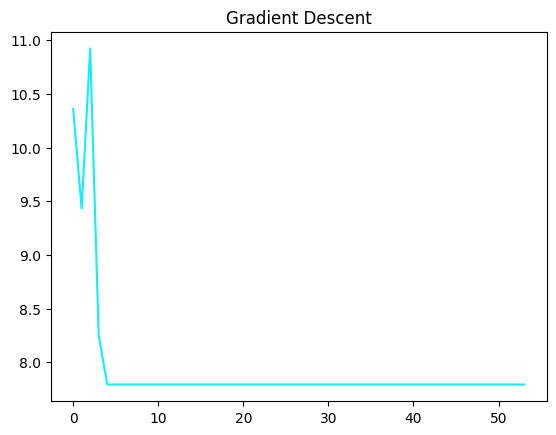

In [71]:
optimizer.switch_mode(GradientDescentInteractor)
gd = optimizer.current_interactor.build(optimizer.modes[GradientDescentInteractor][1])
errs = gd.fit(optimizer.train_exdog, optimizer.train_ans)
plt.plot(list(range(len(errs))), errs, c=SKY_WHITE_SCARF)
plt.title("Gradient Descent")

In [72]:
from model.params.kernel import *

optimizer.switch_mode(SVMInteractor)
svm = optimizer.current_interactor.build({'c': 0.5, "kernel": GaussianKernel(), 'tolerance': 1e-4, 'num_iters': 50})
svm.fit(optimizer.train_exdog, optimizer.train_ans)
preds = svm.predict(optimizer.test_exdog)
print("\n")
print(f'f1_score: {optimizer.metric(optimizer.test_real_ans, preds)}')

 [WARN] SVM 2024-05-23 00:39:11.006357: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:39:11.108036: Processed 0/50 iterations
 [INFO] SVM 2024-05-23 00:39:17.329681: Processed 25/50 iterations
 [INFO] SVM 2024-05-23 00:39:23.575173: Reasonable tolerance 0.0001 was achieved on iteration 49


f1_score: 0.24644549763033174


*this is quite long when data length > 2000 =(*

In [73]:
best_svm_param = optimizer.run_study(n_trials=100)
best_svm_param

[I 2024-05-23 00:39:23,612] A new study created in memory with name: no-name-de94edbe-b903-442c-8eb2-6960c36fa007


 [WARN] SVM 2024-05-23 00:39:23.614958: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:39:23.672993: Processed 0/225 iterations
 [INFO] SVM 2024-05-23 00:39:27.787979: Processed 25/225 iterations
 [INFO] SVM 2024-05-23 00:39:32.029171: Processed 50/225 iterations
 [INFO] SVM 2024-05-23 00:39:35.968639: Processed 75/225 iterations
 [INFO] SVM 2024-05-23 00:39:40.166048: Processed 100/225 iterations
 [INFO] SVM 2024-05-23 00:39:44.352581: Processed 125/225 iterations
 [INFO] SVM 2024-05-23 00:39:48.551297: Processed 150/225 iterations
 [INFO] SVM 2024-05-23 00:39:52.877139: Processed 175/225 iterations
 [INFO] SVM 2024-05-23 00:39:56.901473: Processed 200/225 iterations


[I 2024-05-23 00:40:01,326] Trial 0 finished with value: 0.6616541353383458 and parameters: {'c': 1.4536837707475407, 'kernel': 'Polynomial', 'deg': 15, 'tolerance': 0.00018574096263296265, 'num_iters': 225}. Best is trial 0 with value: 0.6616541353383458.


 [WARN] SVM 2024-05-23 00:40:01.327916: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:40:01.414882: Processed 0/87 iterations
 [INFO] SVM 2024-05-23 00:40:07.899061: Processed 25/87 iterations
 [INFO] SVM 2024-05-23 00:40:13.964880: Processed 50/87 iterations
 [INFO] SVM 2024-05-23 00:40:20.009337: Processed 75/87 iterations


[I 2024-05-23 00:40:22,921] Trial 1 finished with value: 0.7610619469026548 and parameters: {'c': 1.0001713354171506, 'kernel': 'Gaussian', 'gamma': 0.5875573124941419, 'tolerance': 0.007285153090861347, 'num_iters': 87}. Best is trial 1 with value: 0.7610619469026548.


 [WARN] SVM 2024-05-23 00:40:22.922614: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:40:23.006385: Processed 0/385 iterations
 [INFO] SVM 2024-05-23 00:40:29.400381: Processed 25/385 iterations
 [INFO] SVM 2024-05-23 00:40:36.018826: Processed 50/385 iterations
 [INFO] SVM 2024-05-23 00:40:42.205121: Processed 75/385 iterations
 [INFO] SVM 2024-05-23 00:40:48.511320: Processed 100/385 iterations
 [INFO] SVM 2024-05-23 00:40:54.614801: Processed 125/385 iterations


[I 2024-05-23 00:40:59,470] Trial 2 finished with value: 0.7745664739884393 and parameters: {'c': 2.496988579821819, 'kernel': 'Gaussian', 'gamma': 0.40895116027999856, 'tolerance': 0.008837633123000134, 'num_iters': 385}. Best is trial 2 with value: 0.7745664739884393.


 [INFO] SVM 2024-05-23 00:40:59.437437: Reasonable tolerance 0.008837633123000134 was achieved on iteration 143
 [WARN] SVM 2024-05-23 00:40:59.472591: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:40:59.568589: Processed 0/145 iterations
 [INFO] SVM 2024-05-23 00:41:10.585497: Processed 25/145 iterations
 [INFO] SVM 2024-05-23 00:41:24.355733: Processed 50/145 iterations


[I 2024-05-23 00:41:28,265] Trial 3 finished with value: 0.6940639269406392 and parameters: {'c': 1.4878599167654787, 'kernel': 'Linear', 'tolerance': 0.005714165702148852, 'num_iters': 145}. Best is trial 2 with value: 0.7745664739884393.


 [INFO] SVM 2024-05-23 00:41:28.207584: Reasonable tolerance 0.005714165702148852 was achieved on iteration 58
 [WARN] SVM 2024-05-23 00:41:28.268205: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:41:28.365504: Processed 0/447 iterations
 [INFO] SVM 2024-05-23 00:41:34.473719: Processed 25/447 iterations
 [INFO] SVM 2024-05-23 00:41:39.414504: Processed 50/447 iterations
 [INFO] SVM 2024-05-23 00:41:43.345535: Processed 75/447 iterations
 [INFO] SVM 2024-05-23 00:41:47.511628: Processed 100/447 iterations
 [INFO] SVM 2024-05-23 00:41:53.015117: Processed 125/447 iterations
 [INFO] SVM 2024-05-23 00:41:57.638528: Processed 150/447 iterations
 [INFO] SVM 2024-05-23 00:42:02.186791: Processed 175/447 iterations
 [INFO] SVM 2024-05-23 00:42:06.126586: Processed 200/447 iterations
 [INFO] SVM 2024-05-23 00:42:10.960345: Processed 225/447 iterations
 [INFO] SVM 2024-05-23 00:42:15.009084: Processed 250/447 iterations
 [INFO] SVM 2024-05-23 00:42:19.161012: Pro

[I 2024-05-23 00:42:52,181] Trial 4 finished with value: 0.13402061855670103 and parameters: {'c': 0.652908342028205, 'kernel': 'Polynomial', 'deg': 14, 'tolerance': 0.009789219665634123, 'num_iters': 447}. Best is trial 2 with value: 0.7745664739884393.


 [WARN] SVM 2024-05-23 00:42:52.183886: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:42:52.281568: Processed 0/363 iterations
 [INFO] SVM 2024-05-23 00:42:58.944812: Processed 25/363 iterations
 [INFO] SVM 2024-05-23 00:43:06.074572: Processed 50/363 iterations
 [INFO] SVM 2024-05-23 00:43:13.951608: Processed 75/363 iterations


[I 2024-05-23 00:43:19,994] Trial 5 finished with value: 0.6848484848484848 and parameters: {'c': 2.785957126848345, 'kernel': 'Linear', 'tolerance': 0.004648141784217794, 'num_iters': 363}. Best is trial 2 with value: 0.7745664739884393.


 [INFO] SVM 2024-05-23 00:43:19.955626: Reasonable tolerance 0.004648141784217794 was achieved on iteration 93
 [WARN] SVM 2024-05-23 00:43:19.995842: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:43:20.102617: Processed 0/182 iterations
 [INFO] SVM 2024-05-23 00:43:26.845837: Processed 25/182 iterations
 [INFO] SVM 2024-05-23 00:43:33.619445: Processed 50/182 iterations
 [INFO] SVM 2024-05-23 00:43:39.899192: Processed 75/182 iterations
 [INFO] SVM 2024-05-23 00:43:45.946106: Processed 100/182 iterations
 [INFO] SVM 2024-05-23 00:43:52.638867: Processed 125/182 iterations
 [INFO] SVM 2024-05-23 00:43:58.911179: Processed 150/182 iterations
 [INFO] SVM 2024-05-23 00:44:05.268245: Processed 175/182 iterations


[I 2024-05-23 00:44:07,686] Trial 6 finished with value: 0.7380952380952381 and parameters: {'c': 1.7661062426190204, 'kernel': 'Gaussian', 'gamma': 0.3523796326101203, 'tolerance': 0.0069025721412797085, 'num_iters': 182}. Best is trial 2 with value: 0.7745664739884393.


 [WARN] SVM 2024-05-23 00:44:07.689825: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:44:07.808822: Processed 0/71 iterations
 [INFO] SVM 2024-05-23 00:44:13.227701: Processed 25/71 iterations
 [INFO] SVM 2024-05-23 00:44:17.445182: Processed 50/71 iterations


[I 2024-05-23 00:44:21,537] Trial 7 finished with value: 0.15023474178403756 and parameters: {'c': 1.2719207520526392, 'kernel': 'Polynomial', 'deg': 12, 'tolerance': 0.0018863418711744398, 'num_iters': 71}. Best is trial 2 with value: 0.7745664739884393.


 [WARN] SVM 2024-05-23 00:44:21.538477: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:44:21.596435: Processed 0/252 iterations
 [INFO] SVM 2024-05-23 00:44:25.637232: Processed 25/252 iterations
 [INFO] SVM 2024-05-23 00:44:29.967980: Processed 50/252 iterations
 [INFO] SVM 2024-05-23 00:44:33.855744: Processed 75/252 iterations
 [INFO] SVM 2024-05-23 00:44:37.870450: Processed 100/252 iterations
 [INFO] SVM 2024-05-23 00:44:41.974404: Processed 125/252 iterations
 [INFO] SVM 2024-05-23 00:44:45.833455: Processed 150/252 iterations
 [INFO] SVM 2024-05-23 00:44:50.151951: Processed 175/252 iterations
 [INFO] SVM 2024-05-23 00:44:54.263690: Processed 200/252 iterations
 [INFO] SVM 2024-05-23 00:44:58.271322: Processed 225/252 iterations
 [INFO] SVM 2024-05-23 00:45:02.381261: Processed 250/252 iterations


[I 2024-05-23 00:45:02,711] Trial 8 finished with value: 0.6649616368286445 and parameters: {'c': 3.3287592302985036, 'kernel': 'Polynomial', 'deg': 8, 'tolerance': 0.0008605758015968912, 'num_iters': 252}. Best is trial 2 with value: 0.7745664739884393.


 [WARN] SVM 2024-05-23 00:45:02.713806: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:45:02.796395: Processed 0/258 iterations
 [INFO] SVM 2024-05-23 00:45:09.165796: Processed 25/258 iterations
 [INFO] SVM 2024-05-23 00:45:16.060505: Processed 50/258 iterations
 [INFO] SVM 2024-05-23 00:45:22.421251: Processed 75/258 iterations
 [INFO] SVM 2024-05-23 00:45:28.836369: Processed 100/258 iterations
 [INFO] SVM 2024-05-23 00:45:35.608247: Processed 125/258 iterations
 [INFO] SVM 2024-05-23 00:45:42.053299: Processed 150/258 iterations
 [INFO] SVM 2024-05-23 00:45:48.418710: Processed 175/258 iterations
 [INFO] SVM 2024-05-23 00:45:56.253121: Processed 200/258 iterations
 [INFO] SVM 2024-05-23 00:46:04.007696: Processed 225/258 iterations
 [INFO] SVM 2024-05-23 00:46:12.592962: Processed 250/258 iterations


[I 2024-05-23 00:46:15,019] Trial 9 finished with value: 0.8 and parameters: {'c': 3.9441038273413387, 'kernel': 'Gaussian', 'gamma': 0.5098144996944266, 'tolerance': 0.004388909547622403, 'num_iters': 258}. Best is trial 9 with value: 0.8.


 [WARN] SVM 2024-05-23 00:46:15.039875: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:46:15.135875: Processed 0/332 iterations
 [INFO] SVM 2024-05-23 00:46:23.956653: Processed 25/332 iterations
 [INFO] SVM 2024-05-23 00:46:31.189286: Processed 50/332 iterations
 [INFO] SVM 2024-05-23 00:46:38.798062: Processed 75/332 iterations
 [INFO] SVM 2024-05-23 00:46:49.263420: Processed 100/332 iterations
 [INFO] SVM 2024-05-23 00:46:57.165982: Processed 125/332 iterations
 [INFO] SVM 2024-05-23 00:47:04.864045: Processed 150/332 iterations
 [INFO] SVM 2024-05-23 00:47:12.277762: Processed 175/332 iterations
 [INFO] SVM 2024-05-23 00:47:22.843008: Processed 200/332 iterations
 [INFO] SVM 2024-05-23 00:47:32.110800: Processed 225/332 iterations
 [INFO] SVM 2024-05-23 00:47:40.132962: Processed 250/332 iterations
 [INFO] SVM 2024-05-23 00:47:48.383947: Processed 275/332 iterations
 [INFO] SVM 2024-05-23 00:47:57.152920: Processed 300/332 iterations
 [INFO] SVM 2024

[I 2024-05-23 00:48:07,057] Trial 10 finished with value: 0.8900804289544236 and parameters: {'c': 4.926544134972756, 'kernel': 'Gaussian', 'gamma': 0.9521017887115513, 'tolerance': 0.003324626204116826, 'num_iters': 332}. Best is trial 10 with value: 0.8900804289544236.


 [WARN] SVM 2024-05-23 00:48:07.080259: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:48:07.177890: Processed 0/332 iterations
 [INFO] SVM 2024-05-23 00:48:15.551563: Processed 25/332 iterations
 [INFO] SVM 2024-05-23 00:48:22.245161: Processed 50/332 iterations
 [INFO] SVM 2024-05-23 00:48:28.322588: Processed 75/332 iterations
 [INFO] SVM 2024-05-23 00:48:34.687555: Processed 100/332 iterations
 [INFO] SVM 2024-05-23 00:48:40.962467: Processed 125/332 iterations
 [INFO] SVM 2024-05-23 00:48:46.971950: Processed 150/332 iterations
 [INFO] SVM 2024-05-23 00:48:53.406993: Processed 175/332 iterations
 [INFO] SVM 2024-05-23 00:48:59.579685: Processed 200/332 iterations
 [INFO] SVM 2024-05-23 00:49:05.987091: Processed 225/332 iterations
 [INFO] SVM 2024-05-23 00:49:12.425761: Processed 250/332 iterations
 [INFO] SVM 2024-05-23 00:49:18.557805: Processed 275/332 iterations
 [INFO] SVM 2024-05-23 00:49:24.956479: Processed 300/332 iterations
 [INFO] SVM 2024

[I 2024-05-23 00:49:33,150] Trial 11 finished with value: 0.8918918918918919 and parameters: {'c': 4.839614420531888, 'kernel': 'Gaussian', 'gamma': 0.9875753524560547, 'tolerance': 0.0034154980162450594, 'num_iters': 332}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 00:49:33.168714: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:49:33.249716: Processed 0/335 iterations
 [INFO] SVM 2024-05-23 00:49:39.642550: Processed 25/335 iterations
 [INFO] SVM 2024-05-23 00:49:45.861533: Processed 50/335 iterations
 [INFO] SVM 2024-05-23 00:49:53.203509: Processed 75/335 iterations
 [INFO] SVM 2024-05-23 00:50:00.619657: Processed 100/335 iterations
 [INFO] SVM 2024-05-23 00:50:06.846047: Processed 125/335 iterations
 [INFO] SVM 2024-05-23 00:50:13.395310: Processed 150/335 iterations
 [INFO] SVM 2024-05-23 00:50:19.869267: Processed 175/335 iterations
 [INFO] SVM 2024-05-23 00:50:26.769933: Processed 200/335 iterations
 [INFO] SVM 2024-05-23 00:50:33.540296: Processed 225/335 iterations
 [INFO] SVM 2024-05-23 00:50:44.765164: Processed 250/335 iterations
 [INFO] SVM 2024-05-23 00:50:54.060666: Processed 275/335 iterations
 [INFO] SVM 2024-05-23 00:51:01.615766: Processed 300/335 iterations
 [INFO] SVM 2024

[I 2024-05-23 00:51:11,254] Trial 12 finished with value: 0.8877005347593583 and parameters: {'c': 4.942209381769405, 'kernel': 'Gaussian', 'gamma': 0.9874772722342947, 'tolerance': 0.0029010467781060032, 'num_iters': 335}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 00:51:11.273429: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:51:11.355389: Processed 0/481 iterations
 [INFO] SVM 2024-05-23 00:51:17.799428: Processed 25/481 iterations
 [INFO] SVM 2024-05-23 00:51:27.057503: Processed 50/481 iterations
 [INFO] SVM 2024-05-23 00:51:33.486781: Processed 75/481 iterations
 [INFO] SVM 2024-05-23 00:51:39.855072: Processed 100/481 iterations
 [INFO] SVM 2024-05-23 00:51:46.711216: Processed 125/481 iterations
 [INFO] SVM 2024-05-23 00:51:53.775232: Processed 150/481 iterations
 [INFO] SVM 2024-05-23 00:52:02.786020: Processed 175/481 iterations
 [INFO] SVM 2024-05-23 00:52:15.097404: Processed 200/481 iterations
 [INFO] SVM 2024-05-23 00:52:22.582762: Processed 225/481 iterations
 [INFO] SVM 2024-05-23 00:52:32.347318: Processed 250/481 iterations
 [INFO] SVM 2024-05-23 00:52:44.124275: Processed 275/481 iterations
 [INFO] SVM 2024-05-23 00:52:53.772488: Processed 300/481 iterations
 [INFO] SVM 2024

[I 2024-05-23 00:53:46,872] Trial 13 finished with value: 0.7962382445141066 and parameters: {'c': 4.9561853583158735, 'kernel': 'Gaussian', 'gamma': 0.9632705463813148, 'tolerance': 0.0031157391669630456, 'num_iters': 481}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 00:53:46.899261: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:53:46.987911: Processed 0/313 iterations
 [INFO] SVM 2024-05-23 00:53:54.814506: Processed 25/313 iterations
 [INFO] SVM 2024-05-23 00:54:01.913001: Processed 50/313 iterations
 [INFO] SVM 2024-05-23 00:54:09.570611: Processed 75/313 iterations
 [INFO] SVM 2024-05-23 00:54:16.396104: Processed 100/313 iterations
 [INFO] SVM 2024-05-23 00:54:23.413634: Processed 125/313 iterations
 [INFO] SVM 2024-05-23 00:54:29.855666: Processed 150/313 iterations
 [INFO] SVM 2024-05-23 00:54:36.127905: Processed 175/313 iterations
 [INFO] SVM 2024-05-23 00:54:42.903346: Processed 200/313 iterations
 [INFO] SVM 2024-05-23 00:54:49.071690: Processed 225/313 iterations
 [INFO] SVM 2024-05-23 00:54:55.723353: Processed 250/313 iterations
 [INFO] SVM 2024-05-23 00:55:02.270437: Processed 275/313 iterations
 [INFO] SVM 2024-05-23 00:55:08.369054: Processed 300/313 iterations


[I 2024-05-23 00:55:11,919] Trial 14 finished with value: 0.8461538461538461 and parameters: {'c': 4.129250893559859, 'kernel': 'Gaussian', 'gamma': 0.7733527522146608, 'tolerance': 0.003503725546581177, 'num_iters': 313}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 00:55:11.946778: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:55:12.026766: Processed 0/399 iterations
 [INFO] SVM 2024-05-23 00:55:18.400682: Processed 25/399 iterations
 [INFO] SVM 2024-05-23 00:55:25.082903: Processed 50/399 iterations
 [INFO] SVM 2024-05-23 00:55:31.993028: Processed 75/399 iterations
 [INFO] SVM 2024-05-23 00:55:38.833459: Processed 100/399 iterations


[I 2024-05-23 00:55:41,557] Trial 15 finished with value: 0.660436137071651 and parameters: {'c': 4.1688903538855335, 'kernel': 'Gaussian', 'gamma': 0.08112806543536777, 'tolerance': 0.0016981807310737496, 'num_iters': 399}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 00:55:41.513577: Reasonable tolerance 0.0016981807310737496 was achieved on iteration 108
 [WARN] SVM 2024-05-23 00:55:41.594653: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:55:41.678654: Processed 0/293 iterations
 [INFO] SVM 2024-05-23 00:55:48.679814: Processed 25/293 iterations
 [INFO] SVM 2024-05-23 00:55:55.270835: Processed 50/293 iterations
 [INFO] SVM 2024-05-23 00:56:01.947313: Processed 75/293 iterations
 [INFO] SVM 2024-05-23 00:56:08.264281: Processed 100/293 iterations


[I 2024-05-23 00:56:14,510] Trial 16 finished with value: 0.675 and parameters: {'c': 4.427934653189736, 'kernel': 'Linear', 'tolerance': 0.005822505435513211, 'num_iters': 293}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 00:56:14.474180: Reasonable tolerance 0.005822505435513211 was achieved on iteration 122
 [WARN] SVM 2024-05-23 00:56:14.537843: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:56:14.623841: Processed 0/422 iterations
 [INFO] SVM 2024-05-23 00:56:21.327149: Processed 25/422 iterations
 [INFO] SVM 2024-05-23 00:56:29.707612: Processed 50/422 iterations
 [INFO] SVM 2024-05-23 00:56:36.304322: Processed 75/422 iterations
 [INFO] SVM 2024-05-23 00:56:43.055801: Processed 100/422 iterations
 [INFO] SVM 2024-05-23 00:56:49.530202: Processed 125/422 iterations
 [INFO] SVM 2024-05-23 00:56:56.551326: Processed 150/422 iterations
 [INFO] SVM 2024-05-23 00:57:03.921926: Processed 175/422 iterations
 [INFO] SVM 2024-05-23 00:57:10.235264: Processed 200/422 iterations
 [INFO] SVM 2024-05-23 00:57:16.604068: Processed 225/422 iterations
 [INFO] SVM 2024-05-23 00:57:23.612091: Processed 250/422 iterations
 [INFO] SVM 2024-05-23 00:57:31.833448: Pr

[I 2024-05-23 00:58:02,439] Trial 17 finished with value: 0.8438356164383561 and parameters: {'c': 3.444819163399326, 'kernel': 'Gaussian', 'gamma': 0.7540318814481837, 'tolerance': 0.002139474328114789, 'num_iters': 422}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 00:58:02.402169: Reasonable tolerance 0.002139474328114789 was achieved on iteration 372
 [WARN] SVM 2024-05-23 00:58:02.467798: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:58:02.556377: Processed 0/206 iterations
 [INFO] SVM 2024-05-23 00:58:09.326894: Processed 25/206 iterations
 [INFO] SVM 2024-05-23 00:58:15.847996: Processed 50/206 iterations
 [INFO] SVM 2024-05-23 00:58:22.730396: Processed 75/206 iterations
 [INFO] SVM 2024-05-23 00:58:30.913690: Processed 100/206 iterations
 [INFO] SVM 2024-05-23 00:58:39.001890: Processed 125/206 iterations
 [INFO] SVM 2024-05-23 00:58:46.907847: Processed 150/206 iterations
 [INFO] SVM 2024-05-23 00:58:54.556119: Processed 175/206 iterations
 [INFO] SVM 2024-05-23 00:59:00.931542: Processed 200/206 iterations


[I 2024-05-23 00:59:02,459] Trial 18 finished with value: 0.8461538461538461 and parameters: {'c': 3.5461171022325564, 'kernel': 'Gaussian', 'gamma': 0.8158658355046569, 'tolerance': 0.004026422957209356, 'num_iters': 206}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 00:59:02.480355: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:59:02.560356: Processed 0/293 iterations
 [INFO] SVM 2024-05-23 00:59:08.690217: Processed 25/293 iterations
 [INFO] SVM 2024-05-23 00:59:15.113627: Processed 50/293 iterations
 [INFO] SVM 2024-05-23 00:59:21.487040: Processed 75/293 iterations
 [INFO] SVM 2024-05-23 00:59:28.191317: Processed 100/293 iterations


[I 2024-05-23 00:59:35,415] Trial 19 finished with value: 0.6728971962616822 and parameters: {'c': 4.634565640288112, 'kernel': 'Linear', 'tolerance': 0.005406107875718781, 'num_iters': 293}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 00:59:35.383098: Reasonable tolerance 0.005406107875718781 was achieved on iteration 124
 [WARN] SVM 2024-05-23 00:59:35.441134: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 00:59:35.542315: Processed 0/488 iterations
 [INFO] SVM 2024-05-23 00:59:42.195964: Processed 25/488 iterations
 [INFO] SVM 2024-05-23 00:59:48.339976: Processed 50/488 iterations
 [INFO] SVM 2024-05-23 00:59:55.180994: Processed 75/488 iterations
 [INFO] SVM 2024-05-23 01:00:01.979042: Processed 100/488 iterations
 [INFO] SVM 2024-05-23 01:00:08.848225: Processed 125/488 iterations
 [INFO] SVM 2024-05-23 01:00:15.638139: Processed 150/488 iterations
 [INFO] SVM 2024-05-23 01:00:22.089267: Processed 175/488 iterations
 [INFO] SVM 2024-05-23 01:00:28.218174: Processed 200/488 iterations
 [INFO] SVM 2024-05-23 01:00:34.638773: Processed 225/488 iterations
 [INFO] SVM 2024-05-23 01:00:40.968834: Processed 250/488 iterations
 [INFO] SVM 2024-05-23 01:00:47.170506: Pr

[I 2024-05-23 01:01:27,144] Trial 20 finished with value: 0.8365650969529086 and parameters: {'c': 2.2911520325712864, 'kernel': 'Gaussian', 'gamma': 0.8678451243622489, 'tolerance': 0.006876114693391508, 'num_iters': 488}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:01:27.106419: Reasonable tolerance 0.006876114693391508 was achieved on iteration 426
 [WARN] SVM 2024-05-23 01:01:27.167512: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:01:27.250662: Processed 0/342 iterations
 [INFO] SVM 2024-05-23 01:01:33.649502: Processed 25/342 iterations
 [INFO] SVM 2024-05-23 01:01:39.872143: Processed 50/342 iterations
 [INFO] SVM 2024-05-23 01:01:46.196507: Processed 75/342 iterations
 [INFO] SVM 2024-05-23 01:01:52.772243: Processed 100/342 iterations
 [INFO] SVM 2024-05-23 01:01:59.561683: Processed 125/342 iterations
 [INFO] SVM 2024-05-23 01:02:06.480998: Processed 150/342 iterations
 [INFO] SVM 2024-05-23 01:02:13.169562: Processed 175/342 iterations
 [INFO] SVM 2024-05-23 01:02:19.423141: Processed 200/342 iterations
 [INFO] SVM 2024-05-23 01:02:26.184466: Processed 225/342 iterations
 [INFO] SVM 2024-05-23 01:02:34.440287: Processed 250/342 iterations
 [INFO] SVM 2024-05-23 01:02:42.147310: Pr

[I 2024-05-23 01:03:01,196] Trial 21 finished with value: 0.8678304239401496 and parameters: {'c': 4.9248804961639925, 'kernel': 'Gaussian', 'gamma': 0.981703366906156, 'tolerance': 0.0028203823585314217, 'num_iters': 342}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:03:01.224242: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:03:01.339450: Processed 0/337 iterations
 [INFO] SVM 2024-05-23 01:03:08.900609: Processed 25/337 iterations
 [INFO] SVM 2024-05-23 01:03:15.892691: Processed 50/337 iterations
 [INFO] SVM 2024-05-23 01:03:23.562732: Processed 75/337 iterations
 [INFO] SVM 2024-05-23 01:03:32.736887: Processed 100/337 iterations
 [INFO] SVM 2024-05-23 01:03:41.091954: Processed 125/337 iterations
 [INFO] SVM 2024-05-23 01:03:49.533845: Processed 150/337 iterations
 [INFO] SVM 2024-05-23 01:03:56.221545: Processed 175/337 iterations
 [INFO] SVM 2024-05-23 01:04:03.951986: Processed 200/337 iterations
 [INFO] SVM 2024-05-23 01:04:10.392948: Processed 225/337 iterations
 [INFO] SVM 2024-05-23 01:04:17.988789: Processed 250/337 iterations
 [INFO] SVM 2024-05-23 01:04:26.048489: Processed 275/337 iterations
 [INFO] SVM 2024-05-23 01:04:33.456276: Processed 300/337 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:04:45,188] Trial 22 finished with value: 0.8804347826086957 and parameters: {'c': 4.980883503449369, 'kernel': 'Gaussian', 'gamma': 0.9697228051795191, 'tolerance': 0.002785786455030886, 'num_iters': 337}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:04:45.220434: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:04:45.304468: Processed 0/364 iterations
 [INFO] SVM 2024-05-23 01:04:54.567361: Processed 25/364 iterations


[I 2024-05-23 01:04:56,319] Trial 23 finished with value: 0.712468193384224 and parameters: {'c': 0.05211464230337093, 'kernel': 'Gaussian', 'gamma': 0.6760891088244443, 'tolerance': 0.00364670051511097, 'num_iters': 364}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:04:56.267898: Reasonable tolerance 0.00364670051511097 was achieved on iteration 31
 [WARN] SVM 2024-05-23 01:04:56.340688: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:04:56.425269: Processed 0/16 iterations


[I 2024-05-23 01:05:00,635] Trial 24 finished with value: 0.8279883381924198 and parameters: {'c': 4.580047995359553, 'kernel': 'Gaussian', 'gamma': 0.9070067820469951, 'tolerance': 0.0011370415868572255, 'num_iters': 16}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:05:00.665958: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:05:00.761449: Processed 0/424 iterations
 [INFO] SVM 2024-05-23 01:05:07.915779: Processed 25/424 iterations
 [INFO] SVM 2024-05-23 01:05:16.164120: Processed 50/424 iterations
 [INFO] SVM 2024-05-23 01:05:22.997029: Processed 75/424 iterations
 [INFO] SVM 2024-05-23 01:05:29.559110: Processed 100/424 iterations
 [INFO] SVM 2024-05-23 01:05:36.724565: Processed 125/424 iterations
 [INFO] SVM 2024-05-23 01:05:44.692310: Processed 150/424 iterations
 [INFO] SVM 2024-05-23 01:05:51.481179: Processed 175/424 iterations
 [INFO] SVM 2024-05-23 01:05:58.571963: Processed 200/424 iterations
 [INFO] SVM 2024-05-23 01:06:05.571001: Processed 225/424 iterations
 [INFO] SVM 2024-05-23 01:06:14.633497: Processed 250/424 iterations
 [INFO] SVM 2024-05-23 01:06:22.278536: Processed 275/424 iterations
 [INFO] SVM 2024-05-23 01:06:31.376889: Processed 300/424 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:07:09,480] Trial 25 finished with value: 0.8484848484848485 and parameters: {'c': 3.9542473809648095, 'kernel': 'Gaussian', 'gamma': 0.8421673705784425, 'tolerance': 0.0024475573476980244, 'num_iters': 424}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:07:09.502632: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:07:09.587636: Processed 0/268 iterations
 [INFO] SVM 2024-05-23 01:07:15.968467: Processed 25/268 iterations
 [INFO] SVM 2024-05-23 01:07:22.445183: Processed 50/268 iterations
 [INFO] SVM 2024-05-23 01:07:29.661874: Processed 75/268 iterations
 [INFO] SVM 2024-05-23 01:07:37.201679: Processed 100/268 iterations
 [INFO] SVM 2024-05-23 01:07:45.456354: Processed 125/268 iterations
 [INFO] SVM 2024-05-23 01:07:51.855969: Processed 150/268 iterations
 [INFO] SVM 2024-05-23 01:08:01.489733: Processed 175/268 iterations
 [INFO] SVM 2024-05-23 01:08:10.275819: Processed 200/268 iterations
 [INFO] SVM 2024-05-23 01:08:17.062817: Processed 225/268 iterations
 [INFO] SVM 2024-05-23 01:08:23.882356: Processed 250/268 iterations


[I 2024-05-23 01:08:28,390] Trial 26 finished with value: 0.837465564738292 and parameters: {'c': 4.426014269971498, 'kernel': 'Gaussian', 'gamma': 0.6653915689107619, 'tolerance': 0.004965525779605534, 'num_iters': 268}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:08:28.415994: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:08:28.496621: Processed 0/327 iterations
 [INFO] SVM 2024-05-23 01:08:35.453416: Processed 25/327 iterations


[I 2024-05-23 01:08:39,938] Trial 27 finished with value: 0.3274336283185841 and parameters: {'c': 3.7235664801433654, 'kernel': 'Gaussian', 'gamma': 0.017394775045502187, 'tolerance': 0.004176576937373713, 'num_iters': 327}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:08:39.872737: Reasonable tolerance 0.004176576937373713 was achieved on iteration 35
 [WARN] SVM 2024-05-23 01:08:39.978382: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:08:40.000987: Processed 0/293 iterations
 [INFO] SVM 2024-05-23 01:08:44.349588: Processed 25/293 iterations
 [INFO] SVM 2024-05-23 01:08:47.096897: Processed 50/293 iterations
 [INFO] SVM 2024-05-23 01:08:50.111607: Processed 75/293 iterations
 [INFO] SVM 2024-05-23 01:08:54.184879: Processed 100/293 iterations
 [INFO] SVM 2024-05-23 01:08:56.931473: Processed 125/293 iterations
 [INFO] SVM 2024-05-23 01:08:59.318537: Processed 150/293 iterations
 [INFO] SVM 2024-05-23 01:09:01.864103: Processed 175/293 iterations
 [INFO] SVM 2024-05-23 01:09:04.240610: Processed 200/293 iterations
 [INFO] SVM 2024-05-23 01:09:06.586102: Processed 225/293 iterations
 [INFO] SVM 2024-05-23 01:09:09.490777: Processed 250/293 iterations
 [INFO] SVM 2024-05-23 01:09:12.980196: Pro

[I 2024-05-23 01:09:15,683] Trial 28 finished with value: 0.6592592592592592 and parameters: {'c': 4.538759656416678, 'kernel': 'Polynomial', 'deg': 2, 'tolerance': 0.0012677929205924246, 'num_iters': 293}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:09:15.707340: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:09:15.801230: Processed 0/218 iterations
 [INFO] SVM 2024-05-23 01:09:24.593785: Processed 25/218 iterations
 [INFO] SVM 2024-05-23 01:09:33.116769: Processed 50/218 iterations
 [INFO] SVM 2024-05-23 01:09:39.369041: Processed 75/218 iterations


[I 2024-05-23 01:09:45,207] Trial 29 finished with value: 0.676923076923077 and parameters: {'c': 3.108015682179394, 'kernel': 'Linear', 'tolerance': 0.000317166083932275, 'num_iters': 218}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:09:45.163793: Reasonable tolerance 0.000317166083932275 was achieved on iteration 90
 [WARN] SVM 2024-05-23 01:09:45.247476: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:09:45.266467: Processed 0/385 iterations
 [INFO] SVM 2024-05-23 01:09:48.412005: Processed 25/385 iterations
 [INFO] SVM 2024-05-23 01:09:51.843772: Processed 50/385 iterations
 [INFO] SVM 2024-05-23 01:09:55.521959: Processed 75/385 iterations
 [INFO] SVM 2024-05-23 01:09:58.289435: Processed 100/385 iterations
 [INFO] SVM 2024-05-23 01:10:01.600720: Processed 125/385 iterations
 [INFO] SVM 2024-05-23 01:10:04.740402: Processed 150/385 iterations
 [INFO] SVM 2024-05-23 01:10:07.563037: Processed 175/385 iterations
 [INFO] SVM 2024-05-23 01:10:10.444392: Processed 200/385 iterations
 [INFO] SVM 2024-05-23 01:10:13.743509: Processed 225/385 iterations
 [INFO] SVM 2024-05-23 01:10:16.492634: Processed 250/385 iterations
 [INFO] SVM 2024-05-23 01:10:19.113030: Pro

[I 2024-05-23 01:10:32,028] Trial 30 finished with value: 0.45454545454545453 and parameters: {'c': 4.17965462576525, 'kernel': 'Polynomial', 'deg': 1, 'tolerance': 0.0034240410279467045, 'num_iters': 385}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:10:32.054466: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:10:32.154764: Processed 0/347 iterations
 [INFO] SVM 2024-05-23 01:10:38.868610: Processed 25/347 iterations
 [INFO] SVM 2024-05-23 01:10:45.743650: Processed 50/347 iterations
 [INFO] SVM 2024-05-23 01:10:53.969605: Processed 75/347 iterations
 [INFO] SVM 2024-05-23 01:11:01.732324: Processed 100/347 iterations
 [INFO] SVM 2024-05-23 01:11:08.160176: Processed 125/347 iterations
 [INFO] SVM 2024-05-23 01:11:14.841957: Processed 150/347 iterations
 [INFO] SVM 2024-05-23 01:11:23.083008: Processed 175/347 iterations
 [INFO] SVM 2024-05-23 01:11:32.438391: Processed 200/347 iterations
 [INFO] SVM 2024-05-23 01:11:40.446448: Processed 225/347 iterations
 [INFO] SVM 2024-05-23 01:11:48.334098: Processed 250/347 iterations
 [INFO] SVM 2024-05-23 01:11:57.146766: Processed 275/347 iterations
 [INFO] SVM 2024-05-23 01:12:05.630267: Processed 300/347 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:12:20,623] Trial 31 finished with value: 0.8579545454545454 and parameters: {'c': 4.986404931455943, 'kernel': 'Gaussian', 'gamma': 0.9478265949732809, 'tolerance': 0.002692352315254894, 'num_iters': 347}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:12:20.674560: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:12:20.865891: Processed 0/329 iterations
 [INFO] SVM 2024-05-23 01:12:28.534573: Processed 25/329 iterations
 [INFO] SVM 2024-05-23 01:12:36.760690: Processed 50/329 iterations
 [INFO] SVM 2024-05-23 01:12:43.201422: Processed 75/329 iterations
 [INFO] SVM 2024-05-23 01:12:50.239182: Processed 100/329 iterations
 [INFO] SVM 2024-05-23 01:12:58.201542: Processed 125/329 iterations
 [INFO] SVM 2024-05-23 01:13:06.542036: Processed 150/329 iterations
 [INFO] SVM 2024-05-23 01:13:15.060946: Processed 175/329 iterations
 [INFO] SVM 2024-05-23 01:13:22.990250: Processed 200/329 iterations
 [INFO] SVM 2024-05-23 01:13:29.213199: Processed 225/329 iterations
 [INFO] SVM 2024-05-23 01:13:37.686915: Processed 250/329 iterations
 [INFO] SVM 2024-05-23 01:13:46.804330: Processed 275/329 iterations
 [INFO] SVM 2024-05-23 01:13:55.990309: Processed 300/329 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:14:07,904] Trial 32 finished with value: 0.7077534791252486 and parameters: {'c': 4.7527980878652185, 'kernel': 'Gaussian', 'gamma': 0.9896658476675232, 'tolerance': 0.002926390495680136, 'num_iters': 329}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:14:07.932314: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:14:08.027343: Processed 0/307 iterations
 [INFO] SVM 2024-05-23 01:14:17.339029: Processed 25/307 iterations
 [INFO] SVM 2024-05-23 01:14:25.543732: Processed 50/307 iterations
 [INFO] SVM 2024-05-23 01:14:34.023093: Processed 75/307 iterations
 [INFO] SVM 2024-05-23 01:14:41.941853: Processed 100/307 iterations
 [INFO] SVM 2024-05-23 01:14:49.761087: Processed 125/307 iterations
 [INFO] SVM 2024-05-23 01:14:58.465267: Processed 150/307 iterations
 [INFO] SVM 2024-05-23 01:15:06.103938: Processed 175/307 iterations
 [INFO] SVM 2024-05-23 01:15:13.813787: Processed 200/307 iterations
 [INFO] SVM 2024-05-23 01:15:22.512987: Processed 225/307 iterations
 [INFO] SVM 2024-05-23 01:15:28.895669: Processed 250/307 iterations
 [INFO] SVM 2024-05-23 01:15:37.049556: Processed 275/307 iterations
 [INFO] SVM 2024-05-23 01:15:44.772050: Processed 300/307 iterations


[I 2024-05-23 01:15:46,916] Trial 33 finished with value: 0.8476454293628809 and parameters: {'c': 4.324106601894088, 'kernel': 'Gaussian', 'gamma': 0.8714921482431466, 'tolerance': 0.003850662836972064, 'num_iters': 307}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:15:46.942709: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:15:47.028002: Processed 0/371 iterations
 [INFO] SVM 2024-05-23 01:15:56.318558: Processed 25/371 iterations
 [INFO] SVM 2024-05-23 01:16:04.111434: Processed 50/371 iterations
 [INFO] SVM 2024-05-23 01:16:10.574763: Processed 75/371 iterations
 [INFO] SVM 2024-05-23 01:16:18.037111: Processed 100/371 iterations
 [INFO] SVM 2024-05-23 01:16:26.266857: Processed 125/371 iterations
 [INFO] SVM 2024-05-23 01:16:34.263790: Processed 150/371 iterations
 [INFO] SVM 2024-05-23 01:16:43.173095: Processed 175/371 iterations
 [INFO] SVM 2024-05-23 01:16:51.123825: Processed 200/371 iterations
 [INFO] SVM 2024-05-23 01:16:59.105243: Processed 225/371 iterations
 [INFO] SVM 2024-05-23 01:17:05.926534: Processed 250/371 iterations
 [INFO] SVM 2024-05-23 01:17:14.117984: Processed 275/371 iterations
 [INFO] SVM 2024-05-23 01:17:22.694723: Processed 300/371 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:17:45,951] Trial 34 finished with value: 0.8531073446327684 and parameters: {'c': 4.737232549259667, 'kernel': 'Gaussian', 'gamma': 0.9058584735250252, 'tolerance': 0.002248159864247074, 'num_iters': 371}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:17:45.984984: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:17:46.106369: Processed 0/411 iterations
 [INFO] SVM 2024-05-23 01:17:54.384642: Processed 25/411 iterations
 [INFO] SVM 2024-05-23 01:18:05.006094: Processed 50/411 iterations
 [INFO] SVM 2024-05-23 01:18:16.472289: Processed 75/411 iterations
 [INFO] SVM 2024-05-23 01:18:23.652535: Processed 100/411 iterations
 [INFO] SVM 2024-05-23 01:18:32.254300: Processed 125/411 iterations
 [INFO] SVM 2024-05-23 01:18:41.045068: Processed 150/411 iterations
 [INFO] SVM 2024-05-23 01:18:47.394607: Processed 175/411 iterations
 [INFO] SVM 2024-05-23 01:18:57.856399: Processed 200/411 iterations
 [INFO] SVM 2024-05-23 01:19:07.915865: Processed 225/411 iterations
 [INFO] SVM 2024-05-23 01:19:15.633797: Processed 250/411 iterations
 [INFO] SVM 2024-05-23 01:19:24.723028: Processed 275/411 iterations
 [INFO] SVM 2024-05-23 01:19:34.273669: Processed 300/411 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:20:12,111] Trial 35 finished with value: 0.8453038674033149 and parameters: {'c': 4.979393133065893, 'kernel': 'Gaussian', 'gamma': 0.7323558593785158, 'tolerance': 0.0032203270254266545, 'num_iters': 411}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:20:12.159371: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:20:12.267709: Processed 0/249 iterations
 [INFO] SVM 2024-05-23 01:20:20.210586: Processed 25/249 iterations
 [INFO] SVM 2024-05-23 01:20:28.745013: Processed 50/249 iterations
 [INFO] SVM 2024-05-23 01:20:36.714723: Processed 75/249 iterations
 [INFO] SVM 2024-05-23 01:20:45.050884: Processed 100/249 iterations
 [INFO] SVM 2024-05-23 01:20:53.401544: Processed 125/249 iterations
 [INFO] SVM 2024-05-23 01:21:00.061864: Processed 150/249 iterations
 [INFO] SVM 2024-05-23 01:21:07.678587: Processed 175/249 iterations
 [INFO] SVM 2024-05-23 01:21:15.040060: Processed 200/249 iterations


[I 2024-05-23 01:21:21,618] Trial 36 finished with value: 0.7311178247734139 and parameters: {'c': 3.872710329309828, 'kernel': 'Gaussian', 'gamma': 0.2448043279877976, 'tolerance': 9.382153296399586e-05, 'num_iters': 249}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:21:21.560636: Reasonable tolerance 9.382153296399586e-05 was achieved on iteration 220
 [WARN] SVM 2024-05-23 01:21:21.649354: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:21:21.764085: Processed 0/446 iterations
 [INFO] SVM 2024-05-23 01:21:30.756127: Processed 25/446 iterations
 [INFO] SVM 2024-05-23 01:21:38.624211: Processed 50/446 iterations


[I 2024-05-23 01:21:47,063] Trial 37 finished with value: 0.6426426426426426 and parameters: {'c': 1.9081572563572466, 'kernel': 'Linear', 'tolerance': 0.004813253548885005, 'num_iters': 446}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:21:47.027549: Reasonable tolerance 0.004813253548885005 was achieved on iteration 74
 [WARN] SVM 2024-05-23 01:21:47.088125: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:21:47.171345: Processed 0/157 iterations
 [INFO] SVM 2024-05-23 01:21:54.778536: Processed 25/157 iterations
 [INFO] SVM 2024-05-23 01:22:03.337489: Processed 50/157 iterations
 [INFO] SVM 2024-05-23 01:22:09.576210: Processed 75/157 iterations
 [INFO] SVM 2024-05-23 01:22:15.916615: Processed 100/157 iterations
 [INFO] SVM 2024-05-23 01:22:22.296080: Processed 125/157 iterations
 [INFO] SVM 2024-05-23 01:22:29.640629: Processed 150/157 iterations


[I 2024-05-23 01:22:32,855] Trial 38 finished with value: 0.8607594936708861 and parameters: {'c': 2.848174795004906, 'kernel': 'Gaussian', 'gamma': 0.9860409800644222, 'tolerance': 0.006325627797878495, 'num_iters': 157}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:22:32.890830: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:22:32.975257: Processed 0/350 iterations
 [INFO] SVM 2024-05-23 01:22:37.233725: Processed 25/350 iterations
 [INFO] SVM 2024-05-23 01:22:41.532475: Processed 50/350 iterations
 [INFO] SVM 2024-05-23 01:22:45.602565: Processed 75/350 iterations
 [INFO] SVM 2024-05-23 01:22:50.623425: Processed 100/350 iterations
 [INFO] SVM 2024-05-23 01:22:55.344328: Processed 125/350 iterations
 [INFO] SVM 2024-05-23 01:23:00.290838: Processed 150/350 iterations
 [INFO] SVM 2024-05-23 01:23:04.834312: Processed 175/350 iterations
 [INFO] SVM 2024-05-23 01:23:12.400545: Processed 200/350 iterations
 [INFO] SVM 2024-05-23 01:23:19.079724: Processed 225/350 iterations
 [INFO] SVM 2024-05-23 01:23:24.152424: Processed 250/350 iterations
 [INFO] SVM 2024-05-23 01:23:29.397103: Processed 275/350 iterations
 [INFO] SVM 2024-05-23 01:23:34.206425: Processed 300/350 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:23:44,449] Trial 39 finished with value: 0.7489361702127659 and parameters: {'c': 4.691390105354097, 'kernel': 'Polynomial', 'deg': 7, 'tolerance': 0.009122701322253245, 'num_iters': 350}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:23:44.481176: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:23:44.572812: Processed 0/280 iterations
 [INFO] SVM 2024-05-23 01:23:52.299908: Processed 25/280 iterations
 [INFO] SVM 2024-05-23 01:24:01.382792: Processed 50/280 iterations
 [INFO] SVM 2024-05-23 01:24:09.650106: Processed 75/280 iterations
 [INFO] SVM 2024-05-23 01:24:20.182803: Processed 100/280 iterations
 [INFO] SVM 2024-05-23 01:24:29.031973: Processed 125/280 iterations
 [INFO] SVM 2024-05-23 01:24:38.212894: Processed 150/280 iterations
 [INFO] SVM 2024-05-23 01:24:45.616766: Processed 175/280 iterations
 [INFO] SVM 2024-05-23 01:24:52.099615: Processed 200/280 iterations
 [INFO] SVM 2024-05-23 01:24:58.443474: Processed 225/280 iterations
 [INFO] SVM 2024-05-23 01:25:06.603882: Processed 250/280 iterations
 [INFO] SVM 2024-05-23 01:25:13.718042: Processed 275/280 iterations


[I 2024-05-23 01:25:15,944] Trial 40 finished with value: 0.850828729281768 and parameters: {'c': 4.312085760048126, 'kernel': 'Gaussian', 'gamma': 0.8075148256357585, 'tolerance': 0.0015127186468042973, 'num_iters': 280}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:25:15.974118: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:25:16.062881: Processed 0/325 iterations
 [INFO] SVM 2024-05-23 01:25:26.676670: Processed 25/325 iterations
 [INFO] SVM 2024-05-23 01:25:34.215720: Processed 50/325 iterations
 [INFO] SVM 2024-05-23 01:25:42.017481: Processed 75/325 iterations
 [INFO] SVM 2024-05-23 01:25:51.945510: Processed 100/325 iterations
 [INFO] SVM 2024-05-23 01:26:00.361835: Processed 125/325 iterations
 [INFO] SVM 2024-05-23 01:26:10.825643: Processed 150/325 iterations
 [INFO] SVM 2024-05-23 01:26:19.579059: Processed 175/325 iterations
 [INFO] SVM 2024-05-23 01:26:28.013103: Processed 200/325 iterations
 [INFO] SVM 2024-05-23 01:26:34.952510: Processed 225/325 iterations
 [INFO] SVM 2024-05-23 01:26:43.416693: Processed 250/325 iterations
 [INFO] SVM 2024-05-23 01:26:51.014859: Processed 275/325 iterations
 [INFO] SVM 2024-05-23 01:26:57.948490: Processed 300/325 iterations


[I 2024-05-23 01:27:07,015] Trial 41 finished with value: 0.8698060941828255 and parameters: {'c': 4.869395736173528, 'kernel': 'Gaussian', 'gamma': 0.9302547513425206, 'tolerance': 0.0028452563170448253, 'num_iters': 325}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:27:07.049506: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:27:07.134773: Processed 0/318 iterations
 [INFO] SVM 2024-05-23 01:27:14.061735: Processed 25/318 iterations
 [INFO] SVM 2024-05-23 01:27:20.273961: Processed 50/318 iterations
 [INFO] SVM 2024-05-23 01:27:26.652039: Processed 75/318 iterations
 [INFO] SVM 2024-05-23 01:27:33.075537: Processed 100/318 iterations
 [INFO] SVM 2024-05-23 01:27:39.129701: Processed 125/318 iterations
 [INFO] SVM 2024-05-23 01:27:45.560093: Processed 150/318 iterations
 [INFO] SVM 2024-05-23 01:27:51.967346: Processed 175/318 iterations
 [INFO] SVM 2024-05-23 01:27:58.238978: Processed 200/318 iterations
 [INFO] SVM 2024-05-23 01:28:05.213034: Processed 225/318 iterations
 [INFO] SVM 2024-05-23 01:28:11.602144: Processed 250/318 iterations
 [INFO] SVM 2024-05-23 01:28:17.825904: Processed 275/318 iterations
 [INFO] SVM 2024-05-23 01:28:24.305813: Processed 300/318 iterations


[I 2024-05-23 01:28:28,738] Trial 42 finished with value: 0.8279883381924198 and parameters: {'c': 4.770827324519902, 'kernel': 'Gaussian', 'gamma': 0.9049595020441084, 'tolerance': 0.0024806792523101766, 'num_iters': 318}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:28:28.782769: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:28:28.864772: Processed 0/392 iterations
 [INFO] SVM 2024-05-23 01:28:35.434890: Processed 25/392 iterations
 [INFO] SVM 2024-05-23 01:28:41.813199: Processed 50/392 iterations
 [INFO] SVM 2024-05-23 01:28:47.979988: Processed 75/392 iterations
 [INFO] SVM 2024-05-23 01:28:54.524036: Processed 100/392 iterations
 [INFO] SVM 2024-05-23 01:29:00.867391: Processed 125/392 iterations
 [INFO] SVM 2024-05-23 01:29:07.243041: Processed 150/392 iterations
 [INFO] SVM 2024-05-23 01:29:13.653757: Processed 175/392 iterations
 [INFO] SVM 2024-05-23 01:29:19.748693: Processed 200/392 iterations
 [INFO] SVM 2024-05-23 01:29:26.531825: Processed 225/392 iterations
 [INFO] SVM 2024-05-23 01:29:33.073986: Processed 250/392 iterations
 [INFO] SVM 2024-05-23 01:29:39.173314: Processed 275/392 iterations
 [INFO] SVM 2024-05-23 01:29:46.483782: Processed 300/392 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:30:10,178] Trial 43 finished with value: 0.875 and parameters: {'c': 4.994271522721441, 'kernel': 'Gaussian', 'gamma': 0.9082302863528204, 'tolerance': 0.0018537251573195683, 'num_iters': 392}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:30:10.208216: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:30:10.304186: Processed 0/387 iterations
 [INFO] SVM 2024-05-23 01:30:17.096943: Processed 25/387 iterations
 [INFO] SVM 2024-05-23 01:30:23.745475: Processed 50/387 iterations
 [INFO] SVM 2024-05-23 01:30:29.832576: Processed 75/387 iterations
 [INFO] SVM 2024-05-23 01:30:36.343675: Processed 100/387 iterations
 [INFO] SVM 2024-05-23 01:30:42.744929: Processed 125/387 iterations
 [INFO] SVM 2024-05-23 01:30:48.799747: Processed 150/387 iterations
 [INFO] SVM 2024-05-23 01:30:55.299537: Processed 175/387 iterations
 [INFO] SVM 2024-05-23 01:31:01.779232: Processed 200/387 iterations
 [INFO] SVM 2024-05-23 01:31:07.982649: Processed 225/387 iterations
 [INFO] SVM 2024-05-23 01:31:14.823656: Processed 250/387 iterations
 [INFO] SVM 2024-05-23 01:31:22.015471: Processed 275/387 iterations
 [INFO] SVM 2024-05-23 01:31:28.317802: Processed 300/387 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:31:50,907] Trial 44 finished with value: 0.8398058252427184 and parameters: {'c': 4.4939901700076375, 'kernel': 'Gaussian', 'gamma': 0.9118413728978996, 'tolerance': 0.0019157195925020342, 'num_iters': 387}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:31:50.939879: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:31:51.042188: Processed 0/367 iterations
 [INFO] SVM 2024-05-23 01:31:57.628413: Processed 25/367 iterations
 [INFO] SVM 2024-05-23 01:32:04.199808: Processed 50/367 iterations
 [INFO] SVM 2024-05-23 01:32:10.391098: Processed 75/367 iterations
 [INFO] SVM 2024-05-23 01:32:16.732896: Processed 100/367 iterations
 [INFO] SVM 2024-05-23 01:32:23.161187: Processed 125/367 iterations
 [INFO] SVM 2024-05-23 01:32:29.226867: Processed 150/367 iterations
 [INFO] SVM 2024-05-23 01:32:35.675245: Processed 175/367 iterations
 [INFO] SVM 2024-05-23 01:32:42.070944: Processed 200/367 iterations
 [INFO] SVM 2024-05-23 01:32:48.188783: Processed 225/367 iterations
 [INFO] SVM 2024-05-23 01:32:54.791273: Processed 250/367 iterations
 [INFO] SVM 2024-05-23 01:33:01.515836: Processed 275/367 iterations
 [INFO] SVM 2024-05-23 01:33:07.784264: Processed 300/367 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:33:24,887] Trial 45 finished with value: 0.8516483516483516 and parameters: {'c': 4.10169871019834, 'kernel': 'Gaussian', 'gamma': 0.8494796169710429, 'tolerance': 0.004169484429148766, 'num_iters': 367}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:33:24.925746: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:33:25.004741: Processed 0/459 iterations
 [INFO] SVM 2024-05-23 01:33:31.419177: Processed 25/459 iterations
 [INFO] SVM 2024-05-23 01:33:38.074071: Processed 50/459 iterations
 [INFO] SVM 2024-05-23 01:33:44.667299: Processed 75/459 iterations
 [INFO] SVM 2024-05-23 01:33:51.324305: Processed 100/459 iterations
 [INFO] SVM 2024-05-23 01:33:57.807156: Processed 125/459 iterations
 [INFO] SVM 2024-05-23 01:34:04.482771: Processed 150/459 iterations
 [INFO] SVM 2024-05-23 01:34:10.750197: Processed 175/459 iterations
 [INFO] SVM 2024-05-23 01:34:17.010251: Processed 200/459 iterations
 [INFO] SVM 2024-05-23 01:34:23.450734: Processed 225/459 iterations
 [INFO] SVM 2024-05-23 01:34:30.302554: Processed 250/459 iterations


[I 2024-05-23 01:34:34,970] Trial 46 finished with value: 0.8044692737430168 and parameters: {'c': 0.9988835682151589, 'kernel': 'Gaussian', 'gamma': 0.9832097780529708, 'tolerance': 0.0007828585416123331, 'num_iters': 459}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:34:34.943898: Reasonable tolerance 0.0007828585416123331 was achieved on iteration 267
 [WARN] SVM 2024-05-23 01:34:35.009029: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:34:35.065058: Processed 0/400 iterations
 [INFO] SVM 2024-05-23 01:34:38.931012: Processed 25/400 iterations
 [INFO] SVM 2024-05-23 01:34:43.067958: Processed 50/400 iterations
 [INFO] SVM 2024-05-23 01:34:46.894378: Processed 75/400 iterations
 [INFO] SVM 2024-05-23 01:34:50.835914: Processed 100/400 iterations
 [INFO] SVM 2024-05-23 01:34:55.499642: Processed 125/400 iterations
 [INFO] SVM 2024-05-23 01:34:59.550488: Processed 150/400 iterations
 [INFO] SVM 2024-05-23 01:35:03.958936: Processed 175/400 iterations
 [INFO] SVM 2024-05-23 01:35:07.812944: Processed 200/400 iterations
 [INFO] SVM 2024-05-23 01:35:11.816753: Processed 225/400 iterations
 [INFO] SVM 2024-05-23 01:35:15.881703: Processed 250/400 iterations
 [INFO] SVM 2024-05-23 01:35:19.696160: P

[I 2024-05-23 01:35:39,660] Trial 47 finished with value: 0.6592592592592592 and parameters: {'c': 4.9968151621074375, 'kernel': 'Polynomial', 'deg': 5, 'tolerance': 0.0017523870463601314, 'num_iters': 400}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:35:39.679569: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:35:39.768607: Processed 0/434 iterations
 [INFO] SVM 2024-05-23 01:35:46.216789: Processed 25/434 iterations
 [INFO] SVM 2024-05-23 01:35:52.621316: Processed 50/434 iterations
 [INFO] SVM 2024-05-23 01:35:58.747399: Processed 75/434 iterations
 [INFO] SVM 2024-05-23 01:36:05.457582: Processed 100/434 iterations
 [INFO] SVM 2024-05-23 01:36:11.817072: Processed 125/434 iterations


[I 2024-05-23 01:36:13,000] Trial 48 finished with value: 0.6809815950920245 and parameters: {'c': 3.7217461980935753, 'kernel': 'Linear', 'tolerance': 0.003300372308099475, 'num_iters': 434}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:36:12.962552: Reasonable tolerance 0.003300372308099475 was achieved on iteration 128
 [WARN] SVM 2024-05-23 01:36:13.025526: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:36:13.114521: Processed 0/251 iterations
 [INFO] SVM 2024-05-23 01:36:19.187599: Processed 25/251 iterations
 [INFO] SVM 2024-05-23 01:36:25.627111: Processed 50/251 iterations
 [INFO] SVM 2024-05-23 01:36:32.191430: Processed 75/251 iterations
 [INFO] SVM 2024-05-23 01:36:38.384802: Processed 100/251 iterations
 [INFO] SVM 2024-05-23 01:36:45.685291: Processed 125/251 iterations
 [INFO] SVM 2024-05-23 01:36:52.615480: Processed 150/251 iterations
 [INFO] SVM 2024-05-23 01:36:58.728444: Processed 175/251 iterations
 [INFO] SVM 2024-05-23 01:37:05.314261: Processed 200/251 iterations
 [INFO] SVM 2024-05-23 01:37:11.643552: Processed 225/251 iterations
 [INFO] SVM 2024-05-23 01:37:17.850937: Processed 250/251 iterations


[I 2024-05-23 01:37:18,124] Trial 49 finished with value: 0.83008356545961 and parameters: {'c': 4.3200572051863215, 'kernel': 'Gaussian', 'gamma': 0.7030316923152728, 'tolerance': 0.004529620263520378, 'num_iters': 251}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:37:18.150812: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:37:18.235842: Processed 0/233 iterations
 [INFO] SVM 2024-05-23 01:37:25.062774: Processed 25/233 iterations
 [INFO] SVM 2024-05-23 01:37:31.271727: Processed 50/233 iterations
 [INFO] SVM 2024-05-23 01:37:37.604260: Processed 75/233 iterations
 [INFO] SVM 2024-05-23 01:37:44.655593: Processed 100/233 iterations
 [INFO] SVM 2024-05-23 01:37:50.803876: Processed 125/233 iterations
 [INFO] SVM 2024-05-23 01:37:57.199325: Processed 150/233 iterations
 [INFO] SVM 2024-05-23 01:38:03.789885: Processed 175/233 iterations
 [INFO] SVM 2024-05-23 01:38:09.820756: Processed 200/233 iterations
 [INFO] SVM 2024-05-23 01:38:16.236062: Processed 225/233 iterations


[I 2024-05-23 01:38:18,234] Trial 50 finished with value: 0.8516483516483516 and parameters: {'c': 4.6383166036216075, 'kernel': 'Gaussian', 'gamma': 0.807712173934241, 'tolerance': 0.007828491804144487, 'num_iters': 233}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:38:18.255841: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:38:18.337858: Processed 0/337 iterations
 [INFO] SVM 2024-05-23 01:38:24.767435: Processed 25/337 iterations
 [INFO] SVM 2024-05-23 01:38:30.952352: Processed 50/337 iterations
 [INFO] SVM 2024-05-23 01:38:37.605396: Processed 75/337 iterations
 [INFO] SVM 2024-05-23 01:38:44.198922: Processed 100/337 iterations
 [INFO] SVM 2024-05-23 01:38:50.222547: Processed 125/337 iterations
 [INFO] SVM 2024-05-23 01:38:56.855174: Processed 150/337 iterations
 [INFO] SVM 2024-05-23 01:39:03.451740: Processed 175/337 iterations
 [INFO] SVM 2024-05-23 01:39:09.475991: Processed 200/337 iterations
 [INFO] SVM 2024-05-23 01:39:15.866910: Processed 225/337 iterations
 [INFO] SVM 2024-05-23 01:39:22.103868: Processed 250/337 iterations
 [INFO] SVM 2024-05-23 01:39:28.299439: Processed 275/337 iterations
 [INFO] SVM 2024-05-23 01:39:34.669885: Processed 300/337 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:39:43,976] Trial 51 finished with value: 0.718052738336714 and parameters: {'c': 4.794284183041958, 'kernel': 'Gaussian', 'gamma': 0.91906566875193, 'tolerance': 0.002901935945300316, 'num_iters': 337}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:39:44.004495: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:39:44.093050: Processed 0/382 iterations
 [INFO] SVM 2024-05-23 01:39:50.173872: Processed 25/382 iterations
 [INFO] SVM 2024-05-23 01:39:56.658158: Processed 50/382 iterations
 [INFO] SVM 2024-05-23 01:40:03.677894: Processed 75/382 iterations
 [INFO] SVM 2024-05-23 01:40:09.715565: Processed 100/382 iterations
 [INFO] SVM 2024-05-23 01:40:16.179200: Processed 125/382 iterations
 [INFO] SVM 2024-05-23 01:40:22.530997: Processed 150/382 iterations
 [INFO] SVM 2024-05-23 01:40:28.635746: Processed 175/382 iterations
 [INFO] SVM 2024-05-23 01:40:35.124238: Processed 200/382 iterations
 [INFO] SVM 2024-05-23 01:40:41.267493: Processed 225/382 iterations
 [INFO] SVM 2024-05-23 01:40:47.547483: Processed 250/382 iterations
 [INFO] SVM 2024-05-23 01:40:54.044930: Processed 275/382 iterations
 [INFO] SVM 2024-05-23 01:41:00.060634: Processed 300/382 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:41:20,914] Trial 52 finished with value: 0.8342541436464088 and parameters: {'c': 4.801224372299462, 'kernel': 'Gaussian', 'gamma': 0.6042792819667, 'tolerance': 0.0021547440160313183, 'num_iters': 382}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:41:20.951101: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:41:21.037514: Processed 0/307 iterations
 [INFO] SVM 2024-05-23 01:41:27.424161: Processed 25/307 iterations
 [INFO] SVM 2024-05-23 01:41:34.161153: Processed 50/307 iterations
 [INFO] SVM 2024-05-23 01:41:40.221890: Processed 75/307 iterations
 [INFO] SVM 2024-05-23 01:41:46.746625: Processed 100/307 iterations
 [INFO] SVM 2024-05-23 01:41:53.322611: Processed 125/307 iterations
 [INFO] SVM 2024-05-23 01:41:59.412072: Processed 150/307 iterations
 [INFO] SVM 2024-05-23 01:42:06.108382: Processed 175/307 iterations
 [INFO] SVM 2024-05-23 01:42:12.511264: Processed 200/307 iterations
 [INFO] SVM 2024-05-23 01:42:18.697396: Processed 225/307 iterations
 [INFO] SVM 2024-05-23 01:42:25.307953: Processed 250/307 iterations
 [INFO] SVM 2024-05-23 01:42:31.483270: Processed 275/307 iterations
 [INFO] SVM 2024-05-23 01:42:37.927977: Processed 300/307 iterations


[I 2024-05-23 01:42:39,686] Trial 53 finished with value: 0.856338028169014 and parameters: {'c': 4.511001204685064, 'kernel': 'Gaussian', 'gamma': 0.9400197292039696, 'tolerance': 0.0037797711962528, 'num_iters': 307}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:42:39.727006: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:42:39.811644: Processed 0/278 iterations
 [INFO] SVM 2024-05-23 01:42:46.735048: Processed 25/278 iterations
 [INFO] SVM 2024-05-23 01:42:53.330786: Processed 50/278 iterations
 [INFO] SVM 2024-05-23 01:42:59.460743: Processed 75/278 iterations
 [INFO] SVM 2024-05-23 01:43:06.094447: Processed 100/278 iterations
 [INFO] SVM 2024-05-23 01:43:12.404160: Processed 125/278 iterations
 [INFO] SVM 2024-05-23 01:43:18.573788: Processed 150/278 iterations
 [INFO] SVM 2024-05-23 01:43:25.054981: Processed 175/278 iterations
 [INFO] SVM 2024-05-23 01:43:31.225584: Processed 200/278 iterations
 [INFO] SVM 2024-05-23 01:43:37.747836: Processed 225/278 iterations
 [INFO] SVM 2024-05-23 01:43:44.266136: Processed 250/278 iterations
 [INFO] SVM 2024-05-23 01:43:50.287177: Processed 275/278 iterations


[I 2024-05-23 01:43:51,159] Trial 54 finished with value: 0.8067226890756303 and parameters: {'c': 4.8367638341712995, 'kernel': 'Gaussian', 'gamma': 0.4552162487516284, 'tolerance': 0.005360469332975572, 'num_iters': 278}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:43:51.185051: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:43:51.271650: Processed 0/353 iterations
 [INFO] SVM 2024-05-23 01:43:57.832136: Processed 25/353 iterations
 [INFO] SVM 2024-05-23 01:44:04.465610: Processed 50/353 iterations
 [INFO] SVM 2024-05-23 01:44:10.517872: Processed 75/353 iterations
 [INFO] SVM 2024-05-23 01:44:17.017379: Processed 100/353 iterations
 [INFO] SVM 2024-05-23 01:44:23.523668: Processed 125/353 iterations
 [INFO] SVM 2024-05-23 01:44:29.579762: Processed 150/353 iterations
 [INFO] SVM 2024-05-23 01:44:36.057657: Processed 175/353 iterations
 [INFO] SVM 2024-05-23 01:44:42.477417: Processed 200/353 iterations
 [INFO] SVM 2024-05-23 01:44:48.627517: Processed 225/353 iterations
 [INFO] SVM 2024-05-23 01:44:55.239493: Processed 250/353 iterations
 [INFO] SVM 2024-05-23 01:45:01.565736: Processed 275/353 iterations
 [INFO] SVM 2024-05-23 01:45:08.085816: Processed 300/353 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:45:21,455] Trial 55 finished with value: 0.853185595567867 and parameters: {'c': 4.01779376115805, 'kernel': 'Gaussian', 'gamma': 0.8627087981324868, 'tolerance': 0.0025393562554174255, 'num_iters': 353}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:45:21.481214: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:45:21.566858: Processed 0/321 iterations
 [INFO] SVM 2024-05-23 01:45:28.201482: Processed 25/321 iterations
 [INFO] SVM 2024-05-23 01:45:35.102599: Processed 50/321 iterations
 [INFO] SVM 2024-05-23 01:45:41.235277: Processed 75/321 iterations
 [INFO] SVM 2024-05-23 01:45:47.649222: Processed 100/321 iterations
 [INFO] SVM 2024-05-23 01:45:54.227177: Processed 125/321 iterations
 [INFO] SVM 2024-05-23 01:46:00.253715: Processed 150/321 iterations
 [INFO] SVM 2024-05-23 01:46:06.909278: Processed 175/321 iterations
 [INFO] SVM 2024-05-23 01:46:13.320465: Processed 200/321 iterations
 [INFO] SVM 2024-05-23 01:46:19.508143: Processed 225/321 iterations
 [INFO] SVM 2024-05-23 01:46:26.038429: Processed 250/321 iterations
 [INFO] SVM 2024-05-23 01:46:32.409242: Processed 275/321 iterations
 [INFO] SVM 2024-05-23 01:46:38.573204: Processed 300/321 iterations


[I 2024-05-23 01:46:44,102] Trial 56 finished with value: 0.8587257617728532 and parameters: {'c': 4.253305494427765, 'kernel': 'Gaussian', 'gamma': 0.9296624873648035, 'tolerance': 0.003167791720970885, 'num_iters': 321}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:46:44.136607: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:46:44.217215: Processed 0/404 iterations
 [INFO] SVM 2024-05-23 01:46:50.323397: Processed 25/404 iterations
 [INFO] SVM 2024-05-23 01:46:57.068279: Processed 50/404 iterations
 [INFO] SVM 2024-05-23 01:47:03.636182: Processed 75/404 iterations
 [INFO] SVM 2024-05-23 01:47:09.767138: Processed 100/404 iterations
 [INFO] SVM 2024-05-23 01:47:16.291057: Processed 125/404 iterations
 [INFO] SVM 2024-05-23 01:47:22.790781: Processed 150/404 iterations
 [INFO] SVM 2024-05-23 01:47:28.937318: Processed 175/404 iterations
 [INFO] SVM 2024-05-23 01:47:35.460685: Processed 200/404 iterations
 [INFO] SVM 2024-05-23 01:47:41.644618: Processed 225/404 iterations
 [INFO] SVM 2024-05-23 01:47:48.096488: Processed 250/404 iterations
 [INFO] SVM 2024-05-23 01:47:55.103047: Processed 275/404 iterations
 [INFO] SVM 2024-05-23 01:48:01.439095: Processed 300/404 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:48:28,406] Trial 57 finished with value: 0.7705382436260623 and parameters: {'c': 4.539193117444532, 'kernel': 'Gaussian', 'gamma': 0.3604044390138278, 'tolerance': 0.000698559860842001, 'num_iters': 404}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:48:28.431664: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:48:28.514940: Processed 0/295 iterations
 [INFO] SVM 2024-05-23 01:48:35.231847: Processed 25/295 iterations
 [INFO] SVM 2024-05-23 01:48:41.391421: Processed 50/295 iterations
 [INFO] SVM 2024-05-23 01:48:47.825074: Processed 75/295 iterations
 [INFO] SVM 2024-05-23 01:48:54.465825: Processed 100/295 iterations
 [INFO] SVM 2024-05-23 01:49:00.532108: Processed 125/295 iterations


[I 2024-05-23 01:49:07,190] Trial 58 finished with value: 0.6728971962616822 and parameters: {'c': 4.98850698784823, 'kernel': 'Linear', 'tolerance': 0.001409810916987715, 'num_iters': 295}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:49:07.159983: Reasonable tolerance 0.001409810916987715 was achieved on iteration 149
 [WARN] SVM 2024-05-23 01:49:07.226359: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:49:07.307326: Processed 0/360 iterations
 [INFO] SVM 2024-05-23 01:49:13.783033: Processed 25/360 iterations
 [INFO] SVM 2024-05-23 01:49:19.837048: Processed 50/360 iterations
 [INFO] SVM 2024-05-23 01:49:26.339838: Processed 75/360 iterations
 [INFO] SVM 2024-05-23 01:49:33.100725: Processed 100/360 iterations
 [INFO] SVM 2024-05-23 01:49:39.404723: Processed 125/360 iterations
 [INFO] SVM 2024-05-23 01:49:45.818505: Processed 150/360 iterations
 [INFO] SVM 2024-05-23 01:49:52.023219: Processed 175/360 iterations
 [INFO] SVM 2024-05-23 01:49:58.357324: Processed 200/360 iterations
 [INFO] SVM 2024-05-23 01:50:04.858528: Processed 225/360 iterations
 [INFO] SVM 2024-05-23 01:50:11.031278: Processed 250/360 iterations
 [INFO] SVM 2024-05-23 01:50:17.502364: Pr

[I 2024-05-23 01:50:38,824] Trial 59 finished with value: 0.8338028169014085 and parameters: {'c': 4.426881209331506, 'kernel': 'Gaussian', 'gamma': 0.7744297636876182, 'tolerance': 0.0020845999479955153, 'num_iters': 360}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:50:38.861173: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:50:38.916795: Processed 0/337 iterations
 [INFO] SVM 2024-05-23 01:50:43.051164: Processed 25/337 iterations
 [INFO] SVM 2024-05-23 01:50:46.920346: Processed 50/337 iterations
 [INFO] SVM 2024-05-23 01:50:50.827292: Processed 75/337 iterations
 [INFO] SVM 2024-05-23 01:50:55.118032: Processed 100/337 iterations
 [INFO] SVM 2024-05-23 01:50:59.438106: Processed 125/337 iterations
 [INFO] SVM 2024-05-23 01:51:03.762804: Processed 150/337 iterations
 [INFO] SVM 2024-05-23 01:51:07.699368: Processed 175/337 iterations
 [INFO] SVM 2024-05-23 01:51:11.629890: Processed 200/337 iterations
 [INFO] SVM 2024-05-23 01:51:15.779477: Processed 225/337 iterations
 [INFO] SVM 2024-05-23 01:51:19.585525: Processed 250/337 iterations
 [INFO] SVM 2024-05-23 01:51:23.969961: Processed 275/337 iterations
 [INFO] SVM 2024-05-23 01:51:27.779133: Processed 300/337 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:51:33,937] Trial 60 finished with value: 0.7078189300411523 and parameters: {'c': 2.4449885851295288, 'kernel': 'Polynomial', 'deg': 10, 'tolerance': 0.0036118303894439466, 'num_iters': 337}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:51:33.960189: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:51:34.047676: Processed 0/377 iterations
 [INFO] SVM 2024-05-23 01:51:40.146263: Processed 25/377 iterations
 [INFO] SVM 2024-05-23 01:51:46.648487: Processed 50/377 iterations
 [INFO] SVM 2024-05-23 01:51:53.136517: Processed 75/377 iterations
 [INFO] SVM 2024-05-23 01:51:59.276022: Processed 100/377 iterations
 [INFO] SVM 2024-05-23 01:52:05.814304: Processed 125/377 iterations
 [INFO] SVM 2024-05-23 01:52:11.999084: Processed 150/377 iterations
 [INFO] SVM 2024-05-23 01:52:18.382397: Processed 175/377 iterations
 [INFO] SVM 2024-05-23 01:52:24.831800: Processed 200/377 iterations
 [INFO] SVM 2024-05-23 01:52:30.840035: Processed 225/377 iterations
 [INFO] SVM 2024-05-23 01:52:37.329696: Processed 250/377 iterations
 [INFO] SVM 2024-05-23 01:52:43.778653: Processed 275/377 iterations
 [INFO] SVM 2024-05-23 01:52:49.869119: Processed 300/377 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:53:09,802] Trial 61 finished with value: 0.8797814207650273 and parameters: {'c': 4.87182146253288, 'kernel': 'Gaussian', 'gamma': 0.9859223126233423, 'tolerance': 0.0029093339220842814, 'num_iters': 377}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:53:09.840176: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:53:09.919642: Processed 0/374 iterations
 [INFO] SVM 2024-05-23 01:53:16.363433: Processed 25/374 iterations
 [INFO] SVM 2024-05-23 01:53:22.623098: Processed 50/374 iterations
 [INFO] SVM 2024-05-23 01:53:28.917494: Processed 75/374 iterations
 [INFO] SVM 2024-05-23 01:53:35.533834: Processed 100/374 iterations
 [INFO] SVM 2024-05-23 01:53:42.210352: Processed 125/374 iterations
 [INFO] SVM 2024-05-23 01:53:48.657220: Processed 150/374 iterations
 [INFO] SVM 2024-05-23 01:53:55.279492: Processed 175/374 iterations
 [INFO] SVM 2024-05-23 01:54:01.413266: Processed 200/374 iterations
 [INFO] SVM 2024-05-23 01:54:07.965845: Processed 225/374 iterations
 [INFO] SVM 2024-05-23 01:54:14.525327: Processed 250/374 iterations
 [INFO] SVM 2024-05-23 01:54:20.564878: Processed 275/374 iterations
 [INFO] SVM 2024-05-23 01:54:27.058985: Processed 300/374 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:54:45,884] Trial 62 finished with value: 0.8705234159779615 and parameters: {'c': 4.66410557078085, 'kernel': 'Gaussian', 'gamma': 0.9497751251075246, 'tolerance': 0.0028318680754575993, 'num_iters': 374}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:54:45.921720: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:54:46.005723: Processed 0/471 iterations
 [INFO] SVM 2024-05-23 01:54:52.287085: Processed 25/471 iterations
 [INFO] SVM 2024-05-23 01:54:58.764664: Processed 50/471 iterations
 [INFO] SVM 2024-05-23 01:55:05.356799: Processed 75/471 iterations
 [INFO] SVM 2024-05-23 01:55:11.509934: Processed 100/471 iterations
 [INFO] SVM 2024-05-23 01:55:18.049497: Processed 125/471 iterations
 [INFO] SVM 2024-05-23 01:55:24.459139: Processed 150/471 iterations
 [INFO] SVM 2024-05-23 01:55:30.495753: Processed 175/471 iterations
 [INFO] SVM 2024-05-23 01:55:36.898993: Processed 200/471 iterations
 [INFO] SVM 2024-05-23 01:55:43.181678: Processed 225/471 iterations
 [INFO] SVM 2024-05-23 01:55:49.381579: Processed 250/471 iterations
 [INFO] SVM 2024-05-23 01:55:56.004451: Processed 275/471 iterations
 [INFO] SVM 2024-05-23 01:56:02.208768: Processed 300/471 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:56:46,562] Trial 63 finished with value: 0.44155844155844154 and parameters: {'c': 4.640412119726372, 'kernel': 'Gaussian', 'gamma': 0.9560509581895703, 'tolerance': 0.0024086471462707935, 'num_iters': 471}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:56:46.587825: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:56:46.669824: Processed 0/385 iterations
 [INFO] SVM 2024-05-23 01:56:53.124241: Processed 25/385 iterations
 [INFO] SVM 2024-05-23 01:56:59.402798: Processed 50/385 iterations
 [INFO] SVM 2024-05-23 01:57:06.029794: Processed 75/385 iterations
 [INFO] SVM 2024-05-23 01:57:12.395503: Processed 100/385 iterations
 [INFO] SVM 2024-05-23 01:57:18.849520: Processed 125/385 iterations
 [INFO] SVM 2024-05-23 01:57:25.401777: Processed 150/385 iterations
 [INFO] SVM 2024-05-23 01:57:31.508965: Processed 175/385 iterations
 [INFO] SVM 2024-05-23 01:57:37.894658: Processed 200/385 iterations
 [INFO] SVM 2024-05-23 01:57:44.274721: Processed 225/385 iterations
 [INFO] SVM 2024-05-23 01:57:50.316086: Processed 250/385 iterations
 [INFO] SVM 2024-05-23 01:57:56.959388: Processed 275/385 iterations
 [INFO] SVM 2024-05-23 01:58:03.347116: Processed 300/385 iterations
 [INFO] SVM 2024

[I 2024-05-23 01:58:25,065] Trial 64 finished with value: 0.8726287262872628 and parameters: {'c': 4.816916616766449, 'kernel': 'Gaussian', 'gamma': 0.8718684631653542, 'tolerance': 0.004217139715121769, 'num_iters': 385}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 01:58:25.105458: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:58:25.187460: Processed 0/500 iterations
 [INFO] SVM 2024-05-23 01:58:31.295123: Processed 25/500 iterations
 [INFO] SVM 2024-05-23 01:58:38.100513: Processed 50/500 iterations


[I 2024-05-23 01:58:43,480] Trial 65 finished with value: 0.5551330798479087 and parameters: {'c': 0.13744378995684325, 'kernel': 'Gaussian', 'gamma': 0.8676976928629917, 'tolerance': 0.004015469384446191, 'num_iters': 500}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 01:58:43.431951: Reasonable tolerance 0.004015469384446191 was achieved on iteration 68
 [WARN] SVM 2024-05-23 01:58:43.505454: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 01:58:43.596472: Processed 0/420 iterations
 [INFO] SVM 2024-05-23 01:58:50.160364: Processed 25/420 iterations
 [INFO] SVM 2024-05-23 01:58:56.962223: Processed 50/420 iterations
 [INFO] SVM 2024-05-23 01:59:03.344732: Processed 75/420 iterations
 [INFO] SVM 2024-05-23 01:59:09.695479: Processed 100/420 iterations
 [INFO] SVM 2024-05-23 01:59:16.091686: Processed 125/420 iterations
 [INFO] SVM 2024-05-23 01:59:22.247429: Processed 150/420 iterations
 [INFO] SVM 2024-05-23 01:59:28.974910: Processed 175/420 iterations
 [INFO] SVM 2024-05-23 01:59:35.373368: Processed 200/420 iterations
 [INFO] SVM 2024-05-23 01:59:41.483544: Processed 225/420 iterations
 [INFO] SVM 2024-05-23 01:59:47.892225: Processed 250/420 iterations
 [INFO] SVM 2024-05-23 01:59:54.421909: Pro

[I 2024-05-23 02:00:30,748] Trial 66 finished with value: 0.8865435356200527 and parameters: {'c': 4.8124501236933614, 'kernel': 'Gaussian', 'gamma': 0.9882306464425472, 'tolerance': 0.0043911914126552876, 'num_iters': 420}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:00:30.779615: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:00:30.869191: Processed 0/429 iterations
 [INFO] SVM 2024-05-23 02:00:37.320692: Processed 25/429 iterations
 [INFO] SVM 2024-05-23 02:00:43.617207: Processed 50/429 iterations
 [INFO] SVM 2024-05-23 02:00:49.737241: Processed 75/429 iterations
 [INFO] SVM 2024-05-23 02:00:56.234544: Processed 100/429 iterations
 [INFO] SVM 2024-05-23 02:01:02.437157: Processed 125/429 iterations
 [INFO] SVM 2024-05-23 02:01:11.998643: Processed 150/429 iterations
 [INFO] SVM 2024-05-23 02:01:21.793970: Processed 175/429 iterations
 [INFO] SVM 2024-05-23 02:01:28.067265: Processed 200/429 iterations
 [INFO] SVM 2024-05-23 02:01:34.175357: Processed 225/429 iterations
 [INFO] SVM 2024-05-23 02:01:40.203248: Processed 250/429 iterations
 [INFO] SVM 2024-05-23 02:01:46.312257: Processed 275/429 iterations
 [INFO] SVM 2024-05-23 02:01:52.383968: Processed 300/429 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:02:24,422] Trial 67 finished with value: 0.7777777777777778 and parameters: {'c': 4.398582457373342, 'kernel': 'Gaussian', 'gamma': 0.9883374469884233, 'tolerance': 0.004559809890734597, 'num_iters': 429}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:02:24.460794: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:02:24.542083: Processed 0/418 iterations
 [INFO] SVM 2024-05-23 02:02:30.582716: Processed 25/418 iterations
 [INFO] SVM 2024-05-23 02:02:36.715021: Processed 50/418 iterations
 [INFO] SVM 2024-05-23 02:02:42.843686: Processed 75/418 iterations
 [INFO] SVM 2024-05-23 02:02:49.023504: Processed 100/418 iterations
 [INFO] SVM 2024-05-23 02:02:55.228291: Processed 125/418 iterations
 [INFO] SVM 2024-05-23 02:03:01.291091: Processed 150/418 iterations
 [INFO] SVM 2024-05-23 02:03:07.566359: Processed 175/418 iterations
 [INFO] SVM 2024-05-23 02:03:13.738150: Processed 200/418 iterations
 [INFO] SVM 2024-05-23 02:03:19.783108: Processed 225/418 iterations
 [INFO] SVM 2024-05-23 02:03:25.943210: Processed 250/418 iterations
 [INFO] SVM 2024-05-23 02:03:32.025781: Processed 275/418 iterations
 [INFO] SVM 2024-05-23 02:03:38.313557: Processed 300/418 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:04:08,469] Trial 68 finished with value: 0.7183098591549296 and parameters: {'c': 4.874719141397801, 'kernel': 'Gaussian', 'gamma': 0.900232807279944, 'tolerance': 0.005176946675763453, 'num_iters': 418}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:04:08.493506: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:04:08.575110: Processed 0/449 iterations
 [INFO] SVM 2024-05-23 02:04:15.051131: Processed 25/449 iterations
 [INFO] SVM 2024-05-23 02:04:21.150092: Processed 50/449 iterations
 [INFO] SVM 2024-05-23 02:04:27.386717: Processed 75/449 iterations
 [INFO] SVM 2024-05-23 02:04:33.496056: Processed 100/449 iterations
 [INFO] SVM 2024-05-23 02:04:40.010504: Processed 125/449 iterations


[I 2024-05-23 02:04:46,210] Trial 69 finished with value: 0.7337278106508875 and parameters: {'c': 3.7707588425106007, 'kernel': 'Gaussian', 'gamma': 0.21455911021516316, 'tolerance': 0.0034575890638741, 'num_iters': 449}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 02:04:46.170086: Reasonable tolerance 0.0034575890638741 was achieved on iteration 149
 [WARN] SVM 2024-05-23 02:04:46.230540: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:04:46.310198: Processed 0/397 iterations
 [INFO] SVM 2024-05-23 02:04:52.717529: Processed 25/397 iterations
 [INFO] SVM 2024-05-23 02:04:58.967750: Processed 50/397 iterations
 [INFO] SVM 2024-05-23 02:05:05.158086: Processed 75/397 iterations
 [INFO] SVM 2024-05-23 02:05:11.225552: Processed 100/397 iterations
 [INFO] SVM 2024-05-23 02:05:17.472967: Processed 125/397 iterations
 [INFO] SVM 2024-05-23 02:05:24.135736: Processed 150/397 iterations


[I 2024-05-23 02:05:30,246] Trial 70 finished with value: 0.6707692307692308 and parameters: {'c': 4.14576280117737, 'kernel': 'Linear', 'tolerance': 0.00382938689281694, 'num_iters': 397}. Best is trial 11 with value: 0.8918918918918919.


 [INFO] SVM 2024-05-23 02:05:30.215354: Reasonable tolerance 0.00382938689281694 was achieved on iteration 174
 [WARN] SVM 2024-05-23 02:05:30.267315: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:05:30.351315: Processed 0/381 iterations
 [INFO] SVM 2024-05-23 02:05:36.482907: Processed 25/381 iterations
 [INFO] SVM 2024-05-23 02:05:42.524287: Processed 50/381 iterations
 [INFO] SVM 2024-05-23 02:05:48.672522: Processed 75/381 iterations
 [INFO] SVM 2024-05-23 02:05:54.924083: Processed 100/381 iterations
 [INFO] SVM 2024-05-23 02:06:00.906553: Processed 125/381 iterations
 [INFO] SVM 2024-05-23 02:06:07.211927: Processed 150/381 iterations
 [INFO] SVM 2024-05-23 02:06:13.295673: Processed 175/381 iterations
 [INFO] SVM 2024-05-23 02:06:19.367977: Processed 200/381 iterations
 [INFO] SVM 2024-05-23 02:06:25.438212: Processed 225/381 iterations
 [INFO] SVM 2024-05-23 02:06:31.574251: Processed 250/381 iterations
 [INFO] SVM 2024-05-23 02:06:37.842809: Pro

[I 2024-05-23 02:07:03,737] Trial 71 finished with value: 0.8226950354609929 and parameters: {'c': 4.850352822086092, 'kernel': 'Gaussian', 'gamma': 0.9529575209103625, 'tolerance': 0.004287978034681903, 'num_iters': 381}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:07:03.766773: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:07:03.870636: Processed 0/359 iterations
 [INFO] SVM 2024-05-23 02:07:10.007097: Processed 25/359 iterations
 [INFO] SVM 2024-05-23 02:07:16.184325: Processed 50/359 iterations
 [INFO] SVM 2024-05-23 02:07:22.239183: Processed 75/359 iterations
 [INFO] SVM 2024-05-23 02:07:28.798917: Processed 100/359 iterations
 [INFO] SVM 2024-05-23 02:07:35.484513: Processed 125/359 iterations
 [INFO] SVM 2024-05-23 02:07:41.500589: Processed 150/359 iterations
 [INFO] SVM 2024-05-23 02:07:47.609645: Processed 175/359 iterations
 [INFO] SVM 2024-05-23 02:07:53.741991: Processed 200/359 iterations
 [INFO] SVM 2024-05-23 02:07:59.847519: Processed 225/359 iterations
 [INFO] SVM 2024-05-23 02:08:06.007546: Processed 250/359 iterations
 [INFO] SVM 2024-05-23 02:08:12.126921: Processed 275/359 iterations
 [INFO] SVM 2024-05-23 02:08:18.227406: Processed 300/359 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:08:32,620] Trial 72 finished with value: 0.847457627118644 and parameters: {'c': 4.587990164880674, 'kernel': 'Gaussian', 'gamma': 0.8858821809857016, 'tolerance': 0.005754134400366558, 'num_iters': 359}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:08:32.653529: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:08:32.735494: Processed 0/100 iterations
 [INFO] SVM 2024-05-23 02:08:39.073514: Processed 25/100 iterations
 [INFO] SVM 2024-05-23 02:08:45.196171: Processed 50/100 iterations
 [INFO] SVM 2024-05-23 02:08:51.191522: Processed 75/100 iterations


[I 2024-05-23 02:08:57,423] Trial 73 finished with value: 0.8641304347826086 and parameters: {'c': 4.70198529885367, 'kernel': 'Gaussian', 'gamma': 0.8259087997155904, 'tolerance': 0.0048418578079450205, 'num_iters': 100}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:08:57.447469: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:08:57.531208: Processed 0/393 iterations
 [INFO] SVM 2024-05-23 02:09:03.597320: Processed 25/393 iterations
 [INFO] SVM 2024-05-23 02:09:09.723073: Processed 50/393 iterations
 [INFO] SVM 2024-05-23 02:09:15.834837: Processed 75/393 iterations
 [INFO] SVM 2024-05-23 02:09:21.869507: Processed 100/393 iterations
 [INFO] SVM 2024-05-23 02:09:27.995403: Processed 125/393 iterations
 [INFO] SVM 2024-05-23 02:09:34.037801: Processed 150/393 iterations
 [INFO] SVM 2024-05-23 02:09:40.054234: Processed 175/393 iterations
 [INFO] SVM 2024-05-23 02:09:46.125133: Processed 200/393 iterations
 [INFO] SVM 2024-05-23 02:09:52.185156: Processed 225/393 iterations
 [INFO] SVM 2024-05-23 02:09:58.440860: Processed 250/393 iterations
 [INFO] SVM 2024-05-23 02:10:04.855712: Processed 275/393 iterations
 [INFO] SVM 2024-05-23 02:10:10.946629: Processed 300/393 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:10:33,562] Trial 74 finished with value: 0.8877005347593583 and parameters: {'c': 4.981012065159301, 'kernel': 'Gaussian', 'gamma': 0.989047400293408, 'tolerance': 0.0032937512380611773, 'num_iters': 393}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:10:33.597701: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:10:33.680674: Processed 0/411 iterations
 [INFO] SVM 2024-05-23 02:10:39.723765: Processed 25/411 iterations
 [INFO] SVM 2024-05-23 02:10:45.793857: Processed 50/411 iterations
 [INFO] SVM 2024-05-23 02:10:51.780855: Processed 75/411 iterations
 [INFO] SVM 2024-05-23 02:10:58.144144: Processed 100/411 iterations
 [INFO] SVM 2024-05-23 02:11:04.282670: Processed 125/411 iterations
 [INFO] SVM 2024-05-23 02:11:10.335395: Processed 150/411 iterations
 [INFO] SVM 2024-05-23 02:11:16.523394: Processed 175/411 iterations
 [INFO] SVM 2024-05-23 02:11:22.570509: Processed 200/411 iterations
 [INFO] SVM 2024-05-23 02:11:28.713886: Processed 225/411 iterations
 [INFO] SVM 2024-05-23 02:11:34.853616: Processed 250/411 iterations
 [INFO] SVM 2024-05-23 02:11:40.834826: Processed 275/411 iterations
 [INFO] SVM 2024-05-23 02:11:46.921221: Processed 300/411 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:12:14,082] Trial 75 finished with value: 0.8888888888888888 and parameters: {'c': 4.999502378230581, 'kernel': 'Gaussian', 'gamma': 0.9890804415800113, 'tolerance': 0.003039031521295494, 'num_iters': 411}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:12:14.108074: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:12:14.198676: Processed 0/419 iterations
 [INFO] SVM 2024-05-23 02:12:20.283581: Processed 25/419 iterations
 [INFO] SVM 2024-05-23 02:12:26.456639: Processed 50/419 iterations
 [INFO] SVM 2024-05-23 02:12:32.510524: Processed 75/419 iterations
 [INFO] SVM 2024-05-23 02:12:39.126445: Processed 100/419 iterations
 [INFO] SVM 2024-05-23 02:12:45.269140: Processed 125/419 iterations
 [INFO] SVM 2024-05-23 02:12:51.293841: Processed 150/419 iterations
 [INFO] SVM 2024-05-23 02:12:57.769879: Processed 175/419 iterations
 [INFO] SVM 2024-05-23 02:13:03.899782: Processed 200/419 iterations
 [INFO] SVM 2024-05-23 02:13:10.041817: Processed 225/419 iterations
 [INFO] SVM 2024-05-23 02:13:16.254066: Processed 250/419 iterations
 [INFO] SVM 2024-05-23 02:13:22.311434: Processed 275/419 iterations
 [INFO] SVM 2024-05-23 02:13:28.483403: Processed 300/419 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:13:58,364] Trial 76 finished with value: 0.8823529411764706 and parameters: {'c': 4.529584862267808, 'kernel': 'Gaussian', 'gamma': 0.96076758456372, 'tolerance': 0.0030467426383963382, 'num_iters': 419}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:13:58.403241: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:13:58.461017: Processed 0/463 iterations
 [INFO] SVM 2024-05-23 02:14:02.287017: Processed 25/463 iterations
 [INFO] SVM 2024-05-23 02:14:06.479921: Processed 50/463 iterations
 [INFO] SVM 2024-05-23 02:14:10.331677: Processed 75/463 iterations
 [INFO] SVM 2024-05-23 02:14:14.272076: Processed 100/463 iterations
 [INFO] SVM 2024-05-23 02:14:18.155999: Processed 125/463 iterations
 [INFO] SVM 2024-05-23 02:14:21.930920: Processed 150/463 iterations
 [INFO] SVM 2024-05-23 02:14:25.942772: Processed 175/463 iterations
 [INFO] SVM 2024-05-23 02:14:29.712652: Processed 200/463 iterations
 [INFO] SVM 2024-05-23 02:14:33.545363: Processed 225/463 iterations
 [INFO] SVM 2024-05-23 02:14:37.457246: Processed 250/463 iterations
 [INFO] SVM 2024-05-23 02:14:41.230841: Processed 275/463 iterations
 [INFO] SVM 2024-05-23 02:14:45.210573: Processed 300/463 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:15:10,534] Trial 77 finished with value: 0.6578449905482041 and parameters: {'c': 1.9997994274855364, 'kernel': 'Polynomial', 'deg': 4, 'tolerance': 0.003170887658361323, 'num_iters': 463}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:15:10.556548: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:15:10.635604: Processed 0/440 iterations
 [INFO] SVM 2024-05-23 02:15:16.946712: Processed 25/440 iterations
 [INFO] SVM 2024-05-23 02:15:22.977693: Processed 50/440 iterations
 [INFO] SVM 2024-05-23 02:15:29.099670: Processed 75/440 iterations
 [INFO] SVM 2024-05-23 02:15:35.301908: Processed 100/440 iterations
 [INFO] SVM 2024-05-23 02:15:41.277335: Processed 125/440 iterations
 [INFO] SVM 2024-05-23 02:15:47.416744: Processed 150/440 iterations
 [INFO] SVM 2024-05-23 02:15:53.491986: Processed 175/440 iterations
 [INFO] SVM 2024-05-23 02:15:59.784211: Processed 200/440 iterations
 [INFO] SVM 2024-05-23 02:16:07.397128: Processed 225/440 iterations
 [INFO] SVM 2024-05-23 02:16:15.874958: Processed 250/440 iterations
 [INFO] SVM 2024-05-23 02:16:23.871351: Processed 275/440 iterations
 [INFO] SVM 2024-05-23 02:16:31.074778: Processed 300/440 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:17:06,428] Trial 78 finished with value: 0.8705234159779615 and parameters: {'c': 4.4577056072989905, 'kernel': 'Gaussian', 'gamma': 0.9529779120293506, 'tolerance': 0.003481368269284141, 'num_iters': 440}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:17:06.453405: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:17:06.533043: Processed 0/409 iterations
 [INFO] SVM 2024-05-23 02:17:12.615964: Processed 25/409 iterations
 [INFO] SVM 2024-05-23 02:17:18.755116: Processed 50/409 iterations
 [INFO] SVM 2024-05-23 02:17:24.901703: Processed 75/409 iterations
 [INFO] SVM 2024-05-23 02:17:30.943154: Processed 100/409 iterations
 [INFO] SVM 2024-05-23 02:17:37.439504: Processed 125/409 iterations
 [INFO] SVM 2024-05-23 02:17:43.499757: Processed 150/409 iterations
 [INFO] SVM 2024-05-23 02:17:49.555145: Processed 175/409 iterations
 [INFO] SVM 2024-05-23 02:17:55.802374: Processed 200/409 iterations
 [INFO] SVM 2024-05-23 02:18:01.829080: Processed 225/409 iterations
 [INFO] SVM 2024-05-23 02:18:08.062797: Processed 250/409 iterations
 [INFO] SVM 2024-05-23 02:18:14.404784: Processed 275/409 iterations
 [INFO] SVM 2024-05-23 02:18:20.522777: Processed 300/409 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:18:47,518] Trial 79 finished with value: 0.7719298245614035 and parameters: {'c': 4.692764142151415, 'kernel': 'Gaussian', 'gamma': 0.9512340257958627, 'tolerance': 0.0038803023591135297, 'num_iters': 409}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:18:47.546984: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:18:47.627703: Processed 0/413 iterations
 [INFO] SVM 2024-05-23 02:18:53.739489: Processed 25/413 iterations
 [INFO] SVM 2024-05-23 02:18:59.937796: Processed 50/413 iterations
 [INFO] SVM 2024-05-23 02:19:06.255880: Processed 75/413 iterations
 [INFO] SVM 2024-05-23 02:19:12.313137: Processed 100/413 iterations
 [INFO] SVM 2024-05-23 02:19:18.622760: Processed 125/413 iterations
 [INFO] SVM 2024-05-23 02:19:24.824168: Processed 150/413 iterations
 [INFO] SVM 2024-05-23 02:19:30.846180: Processed 175/413 iterations
 [INFO] SVM 2024-05-23 02:19:37.134881: Processed 200/413 iterations
 [INFO] SVM 2024-05-23 02:19:43.732625: Processed 225/413 iterations
 [INFO] SVM 2024-05-23 02:19:49.863814: Processed 250/413 iterations
 [INFO] SVM 2024-05-23 02:19:56.020632: Processed 275/413 iterations
 [INFO] SVM 2024-05-23 02:20:02.044504: Processed 300/413 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:20:29,972] Trial 80 finished with value: 0.8853333333333333 and parameters: {'c': 4.250854618793248, 'kernel': 'Gaussian', 'gamma': 0.9881422565384625, 'tolerance': 0.0026175649414312808, 'num_iters': 413}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:20:29.994866: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:20:30.078833: Processed 0/420 iterations
 [INFO] SVM 2024-05-23 02:20:36.234140: Processed 25/420 iterations
 [INFO] SVM 2024-05-23 02:20:42.215791: Processed 50/420 iterations
 [INFO] SVM 2024-05-23 02:20:48.285903: Processed 75/420 iterations
 [INFO] SVM 2024-05-23 02:20:54.368774: Processed 100/420 iterations
 [INFO] SVM 2024-05-23 02:21:00.424229: Processed 125/420 iterations
 [INFO] SVM 2024-05-23 02:21:06.510060: Processed 150/420 iterations
 [INFO] SVM 2024-05-23 02:21:12.571623: Processed 175/420 iterations
 [INFO] SVM 2024-05-23 02:21:18.843554: Processed 200/420 iterations
 [INFO] SVM 2024-05-23 02:21:25.008486: Processed 225/420 iterations
 [INFO] SVM 2024-05-23 02:21:31.027278: Processed 250/420 iterations
 [INFO] SVM 2024-05-23 02:21:37.235413: Processed 275/420 iterations
 [INFO] SVM 2024-05-23 02:21:43.217191: Processed 300/420 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:22:12,838] Trial 81 finished with value: 0.7874720357941835 and parameters: {'c': 4.5698875969189405, 'kernel': 'Gaussian', 'gamma': 0.9882454607229273, 'tolerance': 0.002611399394695649, 'num_iters': 420}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:22:12.861139: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:22:12.942723: Processed 0/414 iterations
 [INFO] SVM 2024-05-23 02:22:19.314611: Processed 25/414 iterations
 [INFO] SVM 2024-05-23 02:22:25.488277: Processed 50/414 iterations
 [INFO] SVM 2024-05-23 02:22:31.472268: Processed 75/414 iterations
 [INFO] SVM 2024-05-23 02:22:38.022989: Processed 100/414 iterations
 [INFO] SVM 2024-05-23 02:22:44.069472: Processed 125/414 iterations
 [INFO] SVM 2024-05-23 02:22:50.177099: Processed 150/414 iterations
 [INFO] SVM 2024-05-23 02:22:56.422371: Processed 175/414 iterations
 [INFO] SVM 2024-05-23 02:23:02.467538: Processed 200/414 iterations
 [INFO] SVM 2024-05-23 02:23:08.699466: Processed 225/414 iterations
 [INFO] SVM 2024-05-23 02:23:14.967637: Processed 250/414 iterations
 [INFO] SVM 2024-05-23 02:23:21.000304: Processed 275/414 iterations
 [INFO] SVM 2024-05-23 02:23:27.163028: Processed 300/414 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:23:55,211] Trial 82 finished with value: 0.7134268537074149 and parameters: {'c': 4.997728278392903, 'kernel': 'Gaussian', 'gamma': 0.9319288906747174, 'tolerance': 0.003099557581621489, 'num_iters': 414}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:23:55.254959: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:23:55.344329: Processed 0/447 iterations
 [INFO] SVM 2024-05-23 02:24:01.370383: Processed 25/447 iterations
 [INFO] SVM 2024-05-23 02:24:07.619145: Processed 50/447 iterations
 [INFO] SVM 2024-05-23 02:24:13.702922: Processed 75/447 iterations
 [INFO] SVM 2024-05-23 02:24:19.880117: Processed 100/447 iterations
 [INFO] SVM 2024-05-23 02:24:26.039737: Processed 125/447 iterations
 [INFO] SVM 2024-05-23 02:24:32.095793: Processed 150/447 iterations
 [INFO] SVM 2024-05-23 02:24:38.390696: Processed 175/447 iterations
 [INFO] SVM 2024-05-23 02:24:44.465929: Processed 200/447 iterations
 [INFO] SVM 2024-05-23 02:24:50.555354: Processed 225/447 iterations
 [INFO] SVM 2024-05-23 02:24:56.922462: Processed 250/447 iterations
 [INFO] SVM 2024-05-23 02:25:03.003660: Processed 275/447 iterations
 [INFO] SVM 2024-05-23 02:25:09.659588: Processed 300/447 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:25:45,734] Trial 83 finished with value: 0.856353591160221 and parameters: {'c': 3.180588888987465, 'kernel': 'Gaussian', 'gamma': 0.9600321396035927, 'tolerance': 0.0035300701655302316, 'num_iters': 447}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:25:45.755628: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:25:45.836593: Processed 0/433 iterations
 [INFO] SVM 2024-05-23 02:25:51.874265: Processed 25/433 iterations
 [INFO] SVM 2024-05-23 02:25:58.071581: Processed 50/433 iterations
 [INFO] SVM 2024-05-23 02:26:04.128903: Processed 75/433 iterations
 [INFO] SVM 2024-05-23 02:26:10.287525: Processed 100/433 iterations
 [INFO] SVM 2024-05-23 02:26:16.598640: Processed 125/433 iterations
 [INFO] SVM 2024-05-23 02:26:22.622447: Processed 150/433 iterations
 [INFO] SVM 2024-05-23 02:26:28.797205: Processed 175/433 iterations
 [INFO] SVM 2024-05-23 02:26:35.014805: Processed 200/433 iterations
 [INFO] SVM 2024-05-23 02:26:41.074584: Processed 225/433 iterations
 [INFO] SVM 2024-05-23 02:26:47.233514: Processed 250/433 iterations
 [INFO] SVM 2024-05-23 02:26:53.315298: Processed 275/433 iterations
 [INFO] SVM 2024-05-23 02:26:59.500177: Processed 300/433 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:27:32,269] Trial 84 finished with value: 0.85 and parameters: {'c': 4.217304400923473, 'kernel': 'Gaussian', 'gamma': 0.8961123987679638, 'tolerance': 0.0022487015689036044, 'num_iters': 433}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:27:32.294288: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:27:32.378245: Processed 0/344 iterations
 [INFO] SVM 2024-05-23 02:27:38.705814: Processed 25/344 iterations
 [INFO] SVM 2024-05-23 02:27:45.140064: Processed 50/344 iterations
 [INFO] SVM 2024-05-23 02:27:51.194662: Processed 75/344 iterations
 [INFO] SVM 2024-05-23 02:27:58.069679: Processed 100/344 iterations
 [INFO] SVM 2024-05-23 02:28:05.648016: Processed 125/344 iterations
 [INFO] SVM 2024-05-23 02:28:13.010599: Processed 150/344 iterations
 [INFO] SVM 2024-05-23 02:28:20.447253: Processed 175/344 iterations
 [INFO] SVM 2024-05-23 02:28:26.856365: Processed 200/344 iterations
 [INFO] SVM 2024-05-23 02:28:32.574592: Processed 225/344 iterations
 [INFO] SVM 2024-05-23 02:28:38.565313: Processed 250/344 iterations
 [INFO] SVM 2024-05-23 02:28:44.364027: Processed 275/344 iterations
 [INFO] SVM 2024-05-23 02:28:50.145715: Processed 300/344 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:29:00,364] Trial 85 finished with value: 0.8296703296703297 and parameters: {'c': 4.367413998717229, 'kernel': 'Gaussian', 'gamma': 0.550912727224479, 'tolerance': 0.0031351909062729798, 'num_iters': 344}. Best is trial 11 with value: 0.8918918918918919.


 [WARN] SVM 2024-05-23 02:29:00.389439: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:29:00.465402: Processed 0/310 iterations
 [INFO] SVM 2024-05-23 02:29:06.305017: Processed 25/310 iterations
 [INFO] SVM 2024-05-23 02:29:12.068616: Processed 50/310 iterations
 [INFO] SVM 2024-05-23 02:29:17.898668: Processed 75/310 iterations
 [INFO] SVM 2024-05-23 02:29:23.700337: Processed 100/310 iterations
 [INFO] SVM 2024-05-23 02:29:29.635614: Processed 125/310 iterations
 [INFO] SVM 2024-05-23 02:29:35.459957: Processed 150/310 iterations
 [INFO] SVM 2024-05-23 02:29:41.200215: Processed 175/310 iterations
 [INFO] SVM 2024-05-23 02:29:47.060127: Processed 200/310 iterations
 [INFO] SVM 2024-05-23 02:29:52.837023: Processed 225/310 iterations
 [INFO] SVM 2024-05-23 02:29:58.713589: Processed 250/310 iterations
 [INFO] SVM 2024-05-23 02:30:04.516567: Processed 275/310 iterations
 [INFO] SVM 2024-05-23 02:30:10.303839: Processed 300/310 iterations


[I 2024-05-23 02:30:12,979] Trial 86 finished with value: 0.8924731182795699 and parameters: {'c': 4.73246834828467, 'kernel': 'Gaussian', 'gamma': 0.9895957555613791, 'tolerance': 0.002680783935647002, 'num_iters': 310}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:30:13.004117: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:30:13.099771: Processed 0/275 iterations
 [INFO] SVM 2024-05-23 02:30:19.057588: Processed 25/275 iterations
 [INFO] SVM 2024-05-23 02:30:24.876443: Processed 50/275 iterations
 [INFO] SVM 2024-05-23 02:30:30.612490: Processed 75/275 iterations
 [INFO] SVM 2024-05-23 02:30:36.481265: Processed 100/275 iterations
 [INFO] SVM 2024-05-23 02:30:42.649132: Processed 125/275 iterations
 [INFO] SVM 2024-05-23 02:30:48.818768: Processed 150/275 iterations
 [INFO] SVM 2024-05-23 02:30:54.949303: Processed 175/275 iterations
 [INFO] SVM 2024-05-23 02:31:01.009830: Processed 200/275 iterations
 [INFO] SVM 2024-05-23 02:31:07.134977: Processed 225/275 iterations
 [INFO] SVM 2024-05-23 02:31:13.224200: Processed 250/275 iterations


[I 2024-05-23 02:31:19,539] Trial 87 finished with value: 0.8095238095238095 and parameters: {'c': 4.737269807418972, 'kernel': 'Gaussian', 'gamma': 0.9332595248417189, 'tolerance': 0.002650345437806548, 'num_iters': 275}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:31:19.566664: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:31:19.645363: Processed 0/398 iterations
 [INFO] SVM 2024-05-23 02:31:25.773260: Processed 25/398 iterations
 [INFO] SVM 2024-05-23 02:31:31.772098: Processed 50/398 iterations
 [INFO] SVM 2024-05-23 02:31:37.890663: Processed 75/398 iterations
 [INFO] SVM 2024-05-23 02:31:43.921810: Processed 100/398 iterations
 [INFO] SVM 2024-05-23 02:31:49.969708: Processed 125/398 iterations
 [INFO] SVM 2024-05-23 02:31:56.128908: Processed 150/398 iterations
 [INFO] SVM 2024-05-23 02:32:02.134961: Processed 175/398 iterations
 [INFO] SVM 2024-05-23 02:32:08.248519: Processed 200/398 iterations
 [INFO] SVM 2024-05-23 02:32:14.326614: Processed 225/398 iterations
 [INFO] SVM 2024-05-23 02:32:20.556319: Processed 250/398 iterations
 [INFO] SVM 2024-05-23 02:32:26.626050: Processed 275/398 iterations
 [INFO] SVM 2024-05-23 02:32:32.661706: Processed 300/398 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:32:56,885] Trial 88 finished with value: 0.8853333333333333 and parameters: {'c': 4.535370306923276, 'kernel': 'Gaussian', 'gamma': 0.9684535947358037, 'tolerance': 0.0037081179470342487, 'num_iters': 398}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:32:56.912863: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:32:56.994909: Processed 0/306 iterations
 [INFO] SVM 2024-05-23 02:33:03.093889: Processed 25/306 iterations
 [INFO] SVM 2024-05-23 02:33:09.296834: Processed 50/306 iterations
 [INFO] SVM 2024-05-23 02:33:15.423299: Processed 75/306 iterations
 [INFO] SVM 2024-05-23 02:33:21.484735: Processed 100/306 iterations
 [INFO] SVM 2024-05-23 02:33:27.600103: Processed 125/306 iterations


[I 2024-05-23 02:33:28,844] Trial 89 finished with value: 0.6865671641791045 and parameters: {'c': 4.053793489893395, 'kernel': 'Linear', 'tolerance': 0.0036985071841795676, 'num_iters': 306}. Best is trial 86 with value: 0.8924731182795699.


 [INFO] SVM 2024-05-23 02:33:28.814606: Reasonable tolerance 0.0036985071841795676 was achieved on iteration 129
 [WARN] SVM 2024-05-23 02:33:28.880747: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:33:28.961790: Processed 0/367 iterations
 [INFO] SVM 2024-05-23 02:33:35.151605: Processed 25/367 iterations
 [INFO] SVM 2024-05-23 02:33:41.187402: Processed 50/367 iterations
 [INFO] SVM 2024-05-23 02:33:47.316900: Processed 75/367 iterations
 [INFO] SVM 2024-05-23 02:33:53.604388: Processed 100/367 iterations
 [INFO] SVM 2024-05-23 02:33:59.775533: Processed 125/367 iterations
 [INFO] SVM 2024-05-23 02:34:06.039489: Processed 150/367 iterations
 [INFO] SVM 2024-05-23 02:34:12.085926: Processed 175/367 iterations
 [INFO] SVM 2024-05-23 02:34:18.334363: Processed 200/367 iterations
 [INFO] SVM 2024-05-23 02:34:24.389226: Processed 225/367 iterations
 [INFO] SVM 2024-05-23 02:34:30.461066: Processed 250/367 iterations


[I 2024-05-23 02:34:33,442] Trial 90 finished with value: 0.8222222222222222 and parameters: {'c': 1.5515842598443002, 'kernel': 'Gaussian', 'gamma': 0.9898011752158619, 'tolerance': 0.0033530009237196026, 'num_iters': 367}. Best is trial 86 with value: 0.8924731182795699.


 [INFO] SVM 2024-05-23 02:34:33.405771: Reasonable tolerance 0.0033530009237196026 was achieved on iteration 261
 [WARN] SVM 2024-05-23 02:34:33.467913: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:34:33.552229: Processed 0/396 iterations
 [INFO] SVM 2024-05-23 02:34:39.774284: Processed 25/396 iterations
 [INFO] SVM 2024-05-23 02:34:46.341033: Processed 50/396 iterations
 [INFO] SVM 2024-05-23 02:34:52.347382: Processed 75/396 iterations
 [INFO] SVM 2024-05-23 02:34:58.568516: Processed 100/396 iterations
 [INFO] SVM 2024-05-23 02:35:04.616502: Processed 125/396 iterations
 [INFO] SVM 2024-05-23 02:35:11.038875: Processed 150/396 iterations
 [INFO] SVM 2024-05-23 02:35:17.334447: Processed 175/396 iterations
 [INFO] SVM 2024-05-23 02:35:23.381116: Processed 200/396 iterations
 [INFO] SVM 2024-05-23 02:35:29.433064: Processed 225/396 iterations
 [INFO] SVM 2024-05-23 02:35:35.504527: Processed 250/396 iterations
 [INFO] SVM 2024-05-23 02:35:41.526073: P

[I 2024-05-23 02:36:11,056] Trial 91 finished with value: 0.8211143695014663 and parameters: {'c': 4.549269293361072, 'kernel': 'Gaussian', 'gamma': 0.963551415242697, 'tolerance': 0.004004164638837872, 'num_iters': 396}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:36:11.083367: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:36:11.168003: Processed 0/475 iterations
 [INFO] SVM 2024-05-23 02:36:17.472159: Processed 25/475 iterations
 [INFO] SVM 2024-05-23 02:36:23.558451: Processed 50/475 iterations
 [INFO] SVM 2024-05-23 02:36:29.859299: Processed 75/475 iterations
 [INFO] SVM 2024-05-23 02:36:36.040985: Processed 100/475 iterations
 [INFO] SVM 2024-05-23 02:36:42.054989: Processed 125/475 iterations
 [INFO] SVM 2024-05-23 02:36:48.190997: Processed 150/475 iterations
 [INFO] SVM 2024-05-23 02:36:54.278196: Processed 175/475 iterations
 [INFO] SVM 2024-05-23 02:37:00.440888: Processed 200/475 iterations
 [INFO] SVM 2024-05-23 02:37:06.648958: Processed 225/475 iterations
 [INFO] SVM 2024-05-23 02:37:12.834995: Processed 250/475 iterations
 [INFO] SVM 2024-05-23 02:37:19.170047: Processed 275/475 iterations
 [INFO] SVM 2024-05-23 02:37:25.243420: Processed 300/475 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:38:08,501] Trial 92 finished with value: 0.8347826086956521 and parameters: {'c': 4.899824513153063, 'kernel': 'Gaussian', 'gamma': 0.9245072817854301, 'tolerance': 0.004414572118102642, 'num_iters': 475}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:38:08.526156: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:38:08.605191: Processed 0/404 iterations
 [INFO] SVM 2024-05-23 02:38:14.749348: Processed 25/404 iterations
 [INFO] SVM 2024-05-23 02:38:20.850266: Processed 50/404 iterations
 [INFO] SVM 2024-05-23 02:38:26.971370: Processed 75/404 iterations
 [INFO] SVM 2024-05-23 02:38:32.975090: Processed 100/404 iterations
 [INFO] SVM 2024-05-23 02:38:39.209378: Processed 125/404 iterations
 [INFO] SVM 2024-05-23 02:38:45.255224: Processed 150/404 iterations
 [INFO] SVM 2024-05-23 02:38:51.297917: Processed 175/404 iterations
 [INFO] SVM 2024-05-23 02:38:57.491364: Processed 200/404 iterations
 [INFO] SVM 2024-05-23 02:39:03.534009: Processed 225/404 iterations
 [INFO] SVM 2024-05-23 02:39:09.686362: Processed 250/404 iterations
 [INFO] SVM 2024-05-23 02:39:15.870279: Processed 275/404 iterations
 [INFO] SVM 2024-05-23 02:39:21.922955: Processed 300/404 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:39:47,410] Trial 93 finished with value: 0.8579545454545454 and parameters: {'c': 4.2962381003643895, 'kernel': 'Gaussian', 'gamma': 0.9630047274857171, 'tolerance': 0.002978977544994267, 'num_iters': 404}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:39:47.438150: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:39:47.519156: Processed 0/426 iterations
 [INFO] SVM 2024-05-23 02:39:53.791839: Processed 25/426 iterations
 [INFO] SVM 2024-05-23 02:39:59.986355: Processed 50/426 iterations
 [INFO] SVM 2024-05-23 02:40:06.378447: Processed 75/426 iterations
 [INFO] SVM 2024-05-23 02:40:12.354168: Processed 100/426 iterations
 [INFO] SVM 2024-05-23 02:40:18.570476: Processed 125/426 iterations
 [INFO] SVM 2024-05-23 02:40:24.643065: Processed 150/426 iterations
 [INFO] SVM 2024-05-23 02:40:30.715247: Processed 175/426 iterations
 [INFO] SVM 2024-05-23 02:40:36.818474: Processed 200/426 iterations
 [INFO] SVM 2024-05-23 02:40:42.817312: Processed 225/426 iterations
 [INFO] SVM 2024-05-23 02:40:48.899865: Processed 250/426 iterations
 [INFO] SVM 2024-05-23 02:40:54.972702: Processed 275/426 iterations
 [INFO] SVM 2024-05-23 02:41:00.986666: Processed 300/426 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:41:31,575] Trial 94 finished with value: 0.848314606741573 and parameters: {'c': 4.752727102036317, 'kernel': 'Gaussian', 'gamma': 0.8894209790554277, 'tolerance': 0.0024560081729605677, 'num_iters': 426}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:41:31.621447: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:41:31.703409: Processed 0/350 iterations
 [INFO] SVM 2024-05-23 02:41:37.937089: Processed 25/350 iterations
 [INFO] SVM 2024-05-23 02:41:44.017560: Processed 50/350 iterations
 [INFO] SVM 2024-05-23 02:41:50.103602: Processed 75/350 iterations
 [INFO] SVM 2024-05-23 02:41:56.275017: Processed 100/350 iterations
 [INFO] SVM 2024-05-23 02:42:02.295724: Processed 125/350 iterations
 [INFO] SVM 2024-05-23 02:42:08.432407: Processed 150/350 iterations
 [INFO] SVM 2024-05-23 02:42:14.539001: Processed 175/350 iterations
 [INFO] SVM 2024-05-23 02:42:20.702584: Processed 200/350 iterations
 [INFO] SVM 2024-05-23 02:42:26.875244: Processed 225/350 iterations
 [INFO] SVM 2024-05-23 02:42:33.204864: Processed 250/350 iterations
 [INFO] SVM 2024-05-23 02:42:39.401158: Processed 275/350 iterations
 [INFO] SVM 2024-05-23 02:42:45.505268: Processed 300/350 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:42:57,870] Trial 95 finished with value: 0.8633879781420765 and parameters: {'c': 4.4931843532810785, 'kernel': 'Gaussian', 'gamma': 0.9218134393119295, 'tolerance': 0.001948896248284225, 'num_iters': 350}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:42:57.898448: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:42:58.033449: Processed 0/457 iterations
 [INFO] SVM 2024-05-23 02:43:01.880124: Processed 25/457 iterations
 [INFO] SVM 2024-05-23 02:43:05.864909: Processed 50/457 iterations
 [INFO] SVM 2024-05-23 02:43:09.679263: Processed 75/457 iterations
 [INFO] SVM 2024-05-23 02:43:13.442312: Processed 100/457 iterations
 [INFO] SVM 2024-05-23 02:43:17.477470: Processed 125/457 iterations
 [INFO] SVM 2024-05-23 02:43:21.254076: Processed 150/457 iterations
 [INFO] SVM 2024-05-23 02:43:25.230119: Processed 175/457 iterations
 [INFO] SVM 2024-05-23 02:43:29.050463: Processed 200/457 iterations
 [INFO] SVM 2024-05-23 02:43:32.877117: Processed 225/457 iterations
 [INFO] SVM 2024-05-23 02:43:37.083638: Processed 250/457 iterations
 [INFO] SVM 2024-05-23 02:43:40.862848: Processed 275/457 iterations
 [INFO] SVM 2024-05-23 02:43:44.682752: Processed 300/457 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:44:09,183] Trial 96 finished with value: 0.653211009174312 and parameters: {'c': 4.617360482378343, 'kernel': 'Polynomial', 'deg': 10, 'tolerance': 0.003627053861164071, 'num_iters': 457}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:44:09.204625: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:44:09.291318: Processed 0/329 iterations
 [INFO] SVM 2024-05-23 02:44:15.468241: Processed 25/329 iterations
 [INFO] SVM 2024-05-23 02:44:21.868856: Processed 50/329 iterations
 [INFO] SVM 2024-05-23 02:44:27.973502: Processed 75/329 iterations
 [INFO] SVM 2024-05-23 02:44:34.003933: Processed 100/329 iterations
 [INFO] SVM 2024-05-23 02:44:40.104953: Processed 125/329 iterations
 [INFO] SVM 2024-05-23 02:44:46.189669: Processed 150/329 iterations
 [INFO] SVM 2024-05-23 02:44:52.233026: Processed 175/329 iterations
 [INFO] SVM 2024-05-23 02:44:58.380157: Processed 200/329 iterations
 [INFO] SVM 2024-05-23 02:45:04.458729: Processed 225/329 iterations
 [INFO] SVM 2024-05-23 02:45:10.569915: Processed 250/329 iterations
 [INFO] SVM 2024-05-23 02:45:16.746904: Processed 275/329 iterations
 [INFO] SVM 2024-05-23 02:45:22.825568: Processed 300/329 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:45:29,979] Trial 97 finished with value: 0.8802083333333334 and parameters: {'c': 4.862615998557267, 'kernel': 'Gaussian', 'gamma': 0.9665997230588675, 'tolerance': 0.0033218902088276055, 'num_iters': 329}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:45:30.023512: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:45:30.103155: Processed 0/188 iterations
 [INFO] SVM 2024-05-23 02:45:36.220697: Processed 25/188 iterations
 [INFO] SVM 2024-05-23 02:45:42.255359: Processed 50/188 iterations
 [INFO] SVM 2024-05-23 02:45:48.394939: Processed 75/188 iterations
 [INFO] SVM 2024-05-23 02:45:54.459542: Processed 100/188 iterations
 [INFO] SVM 2024-05-23 02:46:00.615026: Processed 125/188 iterations
 [INFO] SVM 2024-05-23 02:46:06.695793: Processed 150/188 iterations
 [INFO] SVM 2024-05-23 02:46:12.682816: Processed 175/188 iterations


[I 2024-05-23 02:46:16,005] Trial 98 finished with value: 0.850828729281768 and parameters: {'c': 4.71614991601943, 'kernel': 'Gaussian', 'gamma': 0.8343757556999987, 'tolerance': 0.001607616371362812, 'num_iters': 188}. Best is trial 86 with value: 0.8924731182795699.


 [WARN] SVM 2024-05-23 02:46:16.045783: No loss function passed, can't build learning curve
 [INFO] SVM 2024-05-23 02:46:16.126786: Processed 0/390 iterations
 [INFO] SVM 2024-05-23 02:46:22.201345: Processed 25/390 iterations
 [INFO] SVM 2024-05-23 02:46:28.394372: Processed 50/390 iterations
 [INFO] SVM 2024-05-23 02:46:34.704083: Processed 75/390 iterations
 [INFO] SVM 2024-05-23 02:46:40.860654: Processed 100/390 iterations
 [INFO] SVM 2024-05-23 02:46:46.943312: Processed 125/390 iterations
 [INFO] SVM 2024-05-23 02:46:52.972107: Processed 150/390 iterations
 [INFO] SVM 2024-05-23 02:46:59.150818: Processed 175/390 iterations
 [INFO] SVM 2024-05-23 02:47:05.197049: Processed 200/390 iterations
 [INFO] SVM 2024-05-23 02:47:11.281193: Processed 225/390 iterations
 [INFO] SVM 2024-05-23 02:47:17.463279: Processed 250/390 iterations
 [INFO] SVM 2024-05-23 02:47:23.505613: Processed 275/390 iterations
 [INFO] SVM 2024-05-23 02:47:29.602051: Processed 300/390 iterations
 [INFO] SVM 2024

[I 2024-05-23 02:47:51,568] Trial 99 finished with value: 0.7372013651877133 and parameters: {'c': 4.422361533945842, 'kernel': 'Gaussian', 'gamma': 0.9331719762766739, 'tolerance': 0.0027776524557394707, 'num_iters': 390}. Best is trial 86 with value: 0.8924731182795699.


 [INFO] LinearClassifierOptimizer 2024-05-23 02:47:51.643783: <class 'model.interactor.impl.svm_interactor.SVMInteractor'> best trial finished with value 0.8924731182795699; best params {'c': 4.73246834828467, 'kernel': 'Gaussian', 'gamma': 0.9895957555613791, 'tolerance': 0.002680783935647002, 'num_iters': 310}


FrozenTrial(number=86, state=1, values=[0.8924731182795699], datetime_start=datetime.datetime(2024, 5, 23, 2, 29, 0, 364449), datetime_complete=datetime.datetime(2024, 5, 23, 2, 30, 12, 979099), params={'c': 4.73246834828467, 'kernel': 'Gaussian', 'gamma': 0.9895957555613791, 'tolerance': 0.002680783935647002, 'num_iters': 310}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'c': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'kernel': CategoricalDistribution(choices=('Polynomial', 'Linear', 'Gaussian')), 'gamma': FloatDistribution(high=0.99, log=False, low=0.001, step=None), 'tolerance': FloatDistribution(high=0.01, log=False, low=1e-06, step=None), 'num_iters': IntDistribution(high=500, log=False, low=10, step=1)}, trial_id=86, value=None)

In [74]:
best_svm_params = fix_kernel_param(best_svm_param.params)
best_svm_params

kernel


{'c': 4.73246834828467,
 'kernel': <model.params.kernel.LinearKernel at 0x185ec102d20>,
 'gamma': 0.9895957555613791,
 'tolerance': 0.002680783935647002,
 'num_iters': 310}

(<model.interactor.impl.svm_interactor.SVMInteractor object at 0x00000185EC184B00>, {'c': 4.73246834828467, 'kernel': 'Gaussian', 'gamma': 0.9895957555613791, 'tolerance': 0.002680783935647002, 'num_iters': 310})
kernel
 [INFO] LinearClassifierOptimizer 2024-05-23 02:47:51.830242: SVMInteractor(<class 'model.interactor.impl.svm_interactor.SVMInteractor'>) successfully added(updated) with params {'c': 4.73246834828467, 'kernel': <model.params.kernel.LinearKernel object at 0x00000185E8515430>, 'gamma': 0.9895957555613791, 'tolerance': 0.002680783935647002, 'num_iters': 310}
 [INFO] SVM 2024-05-23 02:47:51.851243: Processed 0/310 iterations
 [INFO] SVM 2024-05-23 02:47:55.760490: Processed 25/310 iterations
 [INFO] SVM 2024-05-23 02:47:59.161525: Processed 50/310 iterations
 [INFO] SVM 2024-05-23 02:48:02.543175: Processed 75/310 iterations
 [INFO] SVM 2024-05-23 02:48:06.183442: Processed 100/310 iterations
 [INFO] SVM 2024-05-23 02:48:09.553983: Processed 125/310 iterations
 [INFO] SVM 

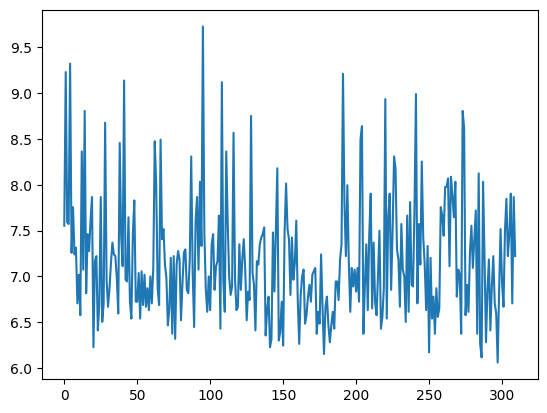

In [75]:
# todo: to remove this cell
override_best_params(SVMInteractor, fix_kernel_param)
best_loss_function = optimizer.modes[GradientDescentInteractor][1]['loss_function']
optimizer.switch_mode(SVMInteractor)
errs = optimizer.current_interactor.build(optimizer.modes[SVMInteractor][1]).fit(
    optimizer.train_exdog,optimizer.train_ans, lambda x,y: best_loss_function.calc_loss(x, y))
plt.plot(list(range(len(errs))), errs)

In [76]:
RIDGE_BEST_PARAMS = optimizer.modes[RidgeRegressionInteractor][1]
GD_BEST_PARAMS = optimizer.modes[GradientDescentInteractor][1]
SVM_BEST_PARAMS = optimizer.modes[SVMInteractor][1]

print(f'Best empirical risk type {GD_BEST_PARAMS['loss_function'].name}')
best_empirical_risk = lambda y_real, y_expect: GD_BEST_PARAMS['loss_function'].calc_loss(y_real, y_expect)

Best empirical risk type FunType.BCE


Common method for klassifier initialization with its best params founded recently

In [77]:
def init_with_best_params(type_token: Type[T], iters: int = -1):
    if type_token not in optimizer.modes:
        raise ValueError('Illegal interactor type. Expected existing instance')
    optimizer.switch_mode(type_token)
    klassifier = optimizer.current_interactor.build(optimizer.modes[type_token][1])
    if iters > 0:
        klassifier.num_iters = iters
    klassifier.pred_transformer = lambda x: np.where(x > 0.0, 1, 0)
    return klassifier

### Plot learning curve with smoothed empirical risk on training set

Found asimptoticaly equal number of iterations for SVM and GD, at it required

In [78]:
best_gd_iters = GD_BEST_PARAMS['num_iters']
best_svm_iters = SVM_BEST_PARAMS['num_iters']
print(f'best iterations for gradient descent: {GD_BEST_PARAMS['num_iters']}')
print(f'best iterations for svm: {SVM_BEST_PARAMS['num_iters']}')
NUM_ITERS = int(10 ** ((np.log10(best_svm_iters) + np.log10(best_gd_iters)) / 2))
print(NUM_ITERS)

best iterations for gradient descent: 54
best iterations for svm: 310
129


In [79]:
optimizer.switch_mode(GradientDescentInteractor)
gd = optimizer.current_interactor.build(GD_BEST_PARAMS)
gd.num_iters = NUM_ITERS
errs_gd = gd.fit(optimizer.train_exdog, optimizer.train_ans)
optimizer.switch_mode(SVMInteractor)
svm = optimizer.current_interactor.build(SVM_BEST_PARAMS)
svm.num_iters = NUM_ITERS
errs_svm = svm.fit(optimizer.train_exdog, optimizer.train_ans, best_empirical_risk)

 [WARN] GradientDescentClassifier 2024-05-23 02:48:38.955016: Loss function is not defined, used default for this instance binary_cross_entropy
 [INFO] SVM 2024-05-23 02:48:39.071376: Processed 0/129 iterations


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [INFO] SVM 2024-05-23 02:48:42.596642: Processed 25/129 iterations
 [INFO] SVM 2024-05-23 02:48:46.255051: Processed 50/129 iterations
 [INFO] SVM 2024-05-23 02:48:49.758346: Processed 75/129 iterations
 [INFO] SVM 2024-05-23 02:48:53.285233: Processed 100/129 iterations
 [INFO] SVM 2024-05-23 02:48:56.997290: Processed 125/129 iterations


num_iters: 129


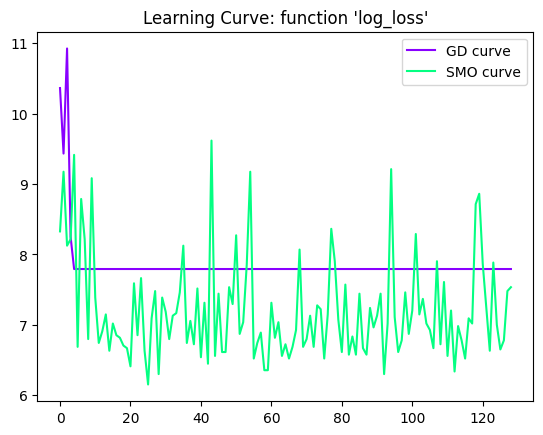

In [80]:
print(f'num_iters: {NUM_ITERS}')
plt.plot(errs_gd, label='GD curve', c=CRY_OF_DESPAIR)
plt.plot(errs_svm, label='SMO curve', c=MINT)
plt.title(f'Learning Curve: function \'{GD_BEST_PARAMS['loss_function'].name.value}\'')
plt.legend()
plt.show()

#### Now, build the learning curve for target error function `f1_score`

In [81]:
from sklearn.metrics import f1_score

optimizer.switch_mode(GradientDescentInteractor)
best_gd_impl = init_with_best_params(GradientDescentInteractor, NUM_ITERS)
errs_gd = best_gd_impl.fit(optimizer.train_exdog, optimizer.train_ans,
                 lambda train_ans, preds_: f1_score(default_transformer(train_ans), default_transformer(preds_)))
optimizer.switch_mode(SVMInteractor)
best_svm_impl = init_with_best_params(SVMInteractor, NUM_ITERS)
errs_svm = best_svm_impl.fit(optimizer.train_exdog, optimizer.train_ans, f1_score)

C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(x))
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\model\klassifier\gradient_descent.py:51: RuntimeWarning: overflow encountere

 [INFO] SVM 2024-05-23 02:48:58.060782: Processed 0/129 iterations
 [INFO] SVM 2024-05-23 02:49:01.526953: Processed 25/129 iterations
 [INFO] SVM 2024-05-23 02:49:05.116270: Processed 50/129 iterations
 [INFO] SVM 2024-05-23 02:49:08.628030: Processed 75/129 iterations
 [INFO] SVM 2024-05-23 02:49:11.984501: Processed 100/129 iterations
 [INFO] SVM 2024-05-23 02:49:15.460696: Processed 125/129 iterations


num_iters: 129


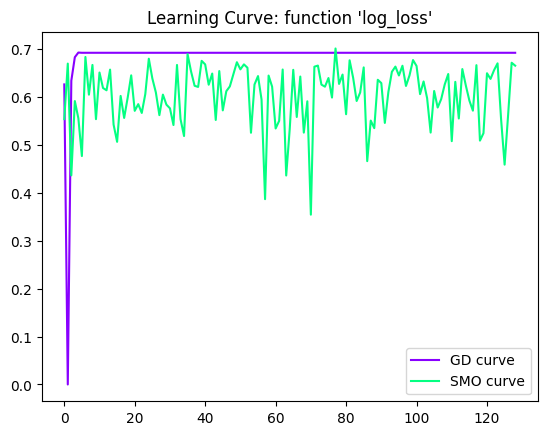

In [82]:
print(f'num_iters: {NUM_ITERS}')
plt.plot(errs_gd, label='GD curve', c=CRY_OF_DESPAIR)
plt.plot(errs_svm, label='SMO curve', c=MINT)
plt.title(f'Learning Curve: function \'{GD_BEST_PARAMS['loss_function'].name.value}\'')
plt.legend()
plt.show()

Add value of error score for the Ridge regression to the plot

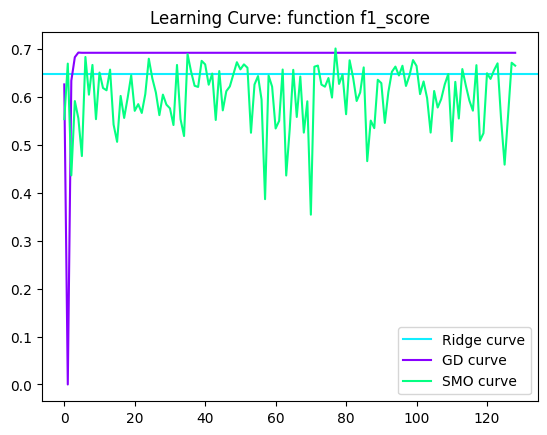

In [83]:
best_ridge_impl = init_with_best_params(RidgeRegressionInteractor)
best_ridge_impl.fit(optimizer.train_exdog, optimizer.train_ans)
ridge_score = f1_score(optimizer.test_real_ans, best_ridge_impl.predict(optimizer.test_exdog))
plt.axhline(y=ridge_score, color=SKY_WHITE_SCARF, linestyle='-', label='Ridge curve')
plt.plot(errs_gd, label='GD curve', c=CRY_OF_DESPAIR)
plt.plot(errs_svm, label='SMO curve', c=MINT)
plt.title(f'Learning Curve: function f1_score')
plt.legend()
plt.show()

### Let's move on to the the library implementations

Here, as for impl versions, firstly test all classifiers with nearly random parameters, then optimize parameters

sklearn.linear_model.RidgeClassifier corresponds to RidgeRegression 

In [84]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier

ridge_lib = RidgeClassifier()
ridge_lib.fit(optimizer.train_exdog, optimizer.train_ans)
lib_ridge_preds = ridge_lib.predict(optimizer.test_exdog)
print(f1_score(optimizer.test_real_ans, np.where(lib_ridge_preds > 0, 1, 0)))

0.6390532544378699


sklearn.linear_model.SGDClassifier corresponds to GradientDescentClassifier 

In [85]:
gd_lib = SGDClassifier(loss='log_loss')  # log_loss <=> bce; squared_error <=> mse; 
gd_lib.fit(optimizer.train_exdog, optimizer.train_ans)
lib_gd_preds = gd_lib.predict(optimizer.test_exdog)
print(f1_score(optimizer.test_real_ans, np.where(lib_gd_preds > 0, 1, 0)))

0.3817427385892116


sklearn.svm.LinearSVC corresponds to SVM

In [86]:
from sklearn import svm

svm_lib = svm.LinearSVC()
svm_lib.fit(optimizer.train_exdog, optimizer.train_ans)
lib_svm_preds = svm_lib.predict(optimizer.test_exdog)
print(f1_score(optimizer.test_real_ans, np.where(lib_svm_preds > 0, 1, 0)))

0.6390532544378699


C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Add type tokens of these classifiers to out optimizer and find the best parameters for library realizations 

In [87]:
from model.interactor.library.lib_ridge_interactor import *
from model.interactor.library.lib_gd_interactor import *
from model.interactor.library.lib_svm_interactor import *

optimizer.add_mode(LibRidgeInteractor, LibRidgeInteractor())
optimizer.add_mode(LibGDInteractor, LibGDInteractor())
optimizer.add_mode(LibSVMInteractor, LibSVMInteractor())

 [INFO] LinearClassifierOptimizer 2024-05-23 02:49:16.532551: LibRidgeInteractor(<class 'model.interactor.library.lib_ridge_interactor.LibRidgeInteractor'>) successfully added(updated)
 [INFO] LinearClassifierOptimizer 2024-05-23 02:49:16.533555: LibGDInteractor(<class 'model.interactor.library.lib_gd_interactor.LibGDInteractor'>) successfully added(updated)
 [INFO] LinearClassifierOptimizer 2024-05-23 02:49:16.533555: LibSVMInteractor(<class 'model.interactor.library.lib_svm_interactor.LibSVMInteractor'>) successfully added(updated)


In [88]:
optimizer.switch_mode(LibRidgeInteractor)
optimizer.run_study(trans=lambda x: np.where(x > 0, 1, 0))

[I 2024-05-23 02:49:16,547] A new study created in memory with name: no-name-7e5176dd-d8bf-4cab-a5cb-4c2e2d3c3221
[I 2024-05-23 02:49:16,562] Trial 0 finished with value: 0.0 and parameters: {'alpha': 2671.8131507691555}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,571] Trial 1 finished with value: 0.0 and parameters: {'alpha': 9806.25024923715}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,580] Trial 2 finished with value: 0.0 and parameters: {'alpha': 2038.0792531584614}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,588] Trial 3 finished with value: 0.0 and parameters: {'alpha': 7385.013759326948}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,598] Trial 4 finished with value: 0.0 and parameters: {'alpha': 8229.41085668437}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,607] Trial 5 finished with value: 0.0 and parameters: {'alpha': 1424.1597904917603}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:16,618] Trial 6 finished 

 [INFO] LinearClassifierOptimizer 2024-05-23 02:49:32.383269: <class 'model.interactor.library.lib_ridge_interactor.LibRidgeInteractor'> best trial finished with value 0.6470588235294118; best params {'alpha': 9.818535398175413}


FrozenTrial(number=16, state=1, values=[0.6470588235294118], datetime_start=datetime.datetime(2024, 5, 23, 2, 49, 16, 733761), datetime_complete=datetime.datetime(2024, 5, 23, 2, 49, 16, 745794), params={'alpha': 9.818535398175413}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=10000.0, log=False, low=0.0, step=None)}, trial_id=16, value=None)

In [89]:
ridge_best = optimizer.current_interactor.build(optimizer.modes[LibRidgeInteractor][1])

In [90]:
optimizer.switch_mode(LibGDInteractor)
optimizer.run_study(trans=lambda x: np.where(x > 0, 1, 0))

[I 2024-05-23 02:49:32,414] A new study created in memory with name: no-name-809822b4-fef7-481b-92ab-1d6b3531a4b3
[I 2024-05-23 02:49:32,422] Trial 0 finished with value: 0.0 and parameters: {'alpha': 960.9017082435004, 'beta': 0.5907761163728955, 'learning_rate': 0.027507780914472715, 'num_iters': 718, 'loss_function': 'squared_error'}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:32,431] Trial 1 finished with value: 0.0 and parameters: {'alpha': 222.23220503608454, 'beta': 0.08228441333524295, 'learning_rate': 0.010783243003159002, 'num_iters': 172, 'loss_function': 'log_loss'}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:32,439] Trial 2 finished with value: 0.0 and parameters: {'alpha': 918.939514105718, 'beta': 0.6209223846548405, 'learning_rate': 0.07288129488587203, 'num_iters': 751, 'loss_function': 'hinge'}. Best is trial 0 with value: 0.0.
[I 2024-05-23 02:49:32,448] Trial 3 finished with value: 0.0 and parameters: {'alpha': 849.9082794069305, 'beta': 0.224187

 [INFO] LinearClassifierOptimizer 2024-05-23 02:50:36.216345: <class 'model.interactor.library.lib_gd_interactor.LibGDInteractor'> best trial finished with value 0.6526717557251909; best params {'alpha': 780.6852111871327, 'beta': 0.6306238165063959, 'learning_rate': 0.08035557020034867, 'num_iters': 775, 'loss_function': 'squared_error'}


FrozenTrial(number=298, state=1, values=[0.6526717557251909], datetime_start=datetime.datetime(2024, 5, 23, 2, 49, 45, 454868), datetime_complete=datetime.datetime(2024, 5, 23, 2, 49, 45, 510828), params={'alpha': 780.6852111871327, 'beta': 0.6306238165063959, 'learning_rate': 0.08035557020034867, 'num_iters': 775, 'loss_function': 'squared_error'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1000.0, log=False, low=0.0, step=None), 'beta': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.1, log=False, low=1e-05, step=None), 'num_iters': IntDistribution(high=1000, log=False, low=10, step=1), 'loss_function': CategoricalDistribution(choices=('squared_error', 'log_loss', 'hinge'))}, trial_id=298, value=None)

In [91]:
optimizer.switch_mode(LibSVMInteractor)
optimizer.run_study(trans=lambda x: np.where(x > 0, 1, 0), n_trials=300)


[I 2024-05-23 02:50:36,225] A new study created in memory with name: no-name-762d20cc-d3af-4f95-8bea-458af9ea1464
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
[I 2024-05-23 02:50:36,235] Trial 0 finished with value: 0.6470588235294118 and parameters: {'c': 0.5729994411603767, 'tolerance': 0.004308628578699428, 'num_iters': 16}. Best is trial 0 with value: 0.6470588235294118.
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to

 [INFO] LinearClassifierOptimizer 2024-05-23 02:50:45.877765: <class 'model.interactor.library.lib_svm_interactor.LibSVMInteractor'> best trial finished with value 0.70995670995671; best params {'c': 4.987522548665063, 'tolerance': 0.0031050583559350587, 'num_iters': 17}


FrozenTrial(number=121, state=1, values=[0.70995670995671], datetime_start=datetime.datetime(2024, 5, 23, 2, 50, 39, 595294), datetime_complete=datetime.datetime(2024, 5, 23, 2, 50, 39, 624277), params={'c': 4.987522548665063, 'tolerance': 0.0031050583559350587, 'num_iters': 17}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'c': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'tolerance': FloatDistribution(high=0.01, log=False, low=1e-06, step=None), 'num_iters': IntDistribution(high=500, log=False, low=10, step=1)}, trial_id=121, value=None)

In [92]:
LIB_RIDGE_BEST_PARAMS = optimizer.modes[LibRidgeInteractor][1]
LIB_GD_BEST_PARAMS = optimizer.modes[LibGDInteractor][1]
LIB_SVM_BEST_PARAMS = optimizer.modes[LibSVMInteractor][1]

Add to previous plot results of the library methods

In [93]:
from typing import Tuple

R = TypeVar('R')
M = TypeVar('M')
def get_lib_f1_with_best_params(lib_type_token : Type[R], best_params : Dict[str, Any]) -> Tuple[float, M]:
    optimizer.switch_mode(lib_type_token)
    lib_model = optimizer.current_interactor.build(best_params)
    lib_model.fit(optimizer.train_exdog, optimizer.train_ans)
    return f1_score(optimizer.test_real_ans, default_transformer(lib_model.predict(optimizer.test_exdog))), lib_model

In [94]:
ridge_f1, best_lib_ridge = get_lib_f1_with_best_params(LibRidgeInteractor, LIB_RIDGE_BEST_PARAMS)
gd_f1, best_lib_gd = get_lib_f1_with_best_params(LibGDInteractor, LIB_GD_BEST_PARAMS)
svm_f1, best_lib_svm = get_lib_f1_with_best_params(LibSVMInteractor, LIB_SVM_BEST_PARAMS)

C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\chura\H_yn_a\DA_ML\lab2-linear-BrainCallus\linear\.venv\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


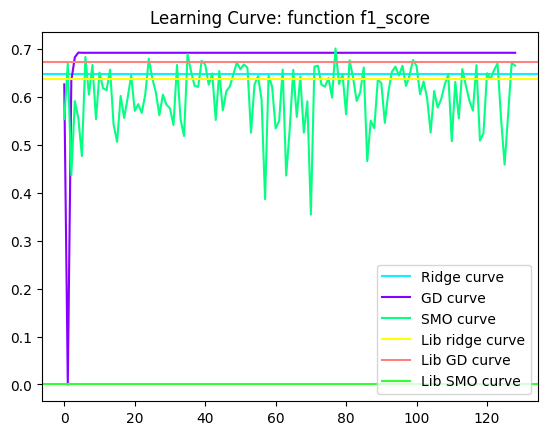

In [95]:
plt.axhline(y=ridge_score, color=SKY_WHITE_SCARF, linestyle='-', label='Ridge curve')
plt.plot(errs_gd, label='GD curve', c=CRY_OF_DESPAIR)
plt.plot(errs_svm, label='SMO curve', c=MINT)

plt.axhline(y=ridge_f1 - 0.01, color=YELLOW_SEND, linestyle='-', label='Lib ridge curve')
# here 0.01 subtracted since library and my implementation performed the same results(if make +0.01, it intersects with lib svm line)
plt.axhline(y=gd_f1, color=BLOOD, linestyle='-', label='Lib GD curve')
plt.axhline(y=svm_f1, color='#33ff33', linestyle='-', label='Lib SMO curve')
plt.title(f'Learning Curve: function f1_score')
plt.legend()
plt.show()

**Coeficients for regression**

In [96]:
#best_lib_ridge.intercept_
print(f'Ridge regression equation: \n\t{best_lib_ridge.coef_[0]} ⋅ X + {best_lib_ridge.intercept_[0]}')
print(f'SGD regression equation: \n\t{best_lib_gd.coef_[0]}⋅ X + {best_lib_gd.intercept_[0]}')

Ridge regression equation: 
	[-0.85132046  0.05479886  0.13155589  0.42819472  1.15421853 -0.64749233
  0.14438406 -0.38717156] ⋅ X + -0.19896733800110133
SGD regression equation: 
	[-0.03587009 -0.09464518 -0.0157742   0.         -0.00410196 -0.03454123
 -0.08675808 -0.04878054]⋅ X + 0.2294037901419705


Vectors for SVM

In [97]:
support_vector_indices = np.where(np.abs(best_lib_svm.decision_function(optimizer.train_exdog)) <= 1 + 1e-15)[0]
print(f'Library support indices {support_vector_indices} - length {len(support_vector_indices)}\n')
lib_support_vectors = np.array(optimizer.train_exdog)[support_vector_indices]
print(f'Lib support vectors of shape {lib_support_vectors.shape}')
print(lib_support_vectors)
print('\n\n')

print(f'Impl support indices {best_svm_impl.supported_indices} - length {len(best_svm_impl.supported_indices)}\n')
impl_support_vectors = np.array(optimizer.train_exdog)[best_svm_impl.supported_indices]
print(f'Impl support vectors of shape {impl_support_vectors.shape}')
print(impl_support_vectors)

Library support indices [   0    3    5    6    7   10   11   13   14   16   21   22   25   26
   28   30   33   35   36   37   40   41   44   45   46   49   51   52
   54   55   57   58   61   66   68   70   72   73   74   75   76   77
   79   82   87   89   91   93   94   96   97   99  100  102  103  108
  109  110  111  112  114  115  117  119  120  121  123  130  132  135
  136  137  138  140  141  143  144  146  147  149  150  151  152  154
  155  156  160  166  167  169  170  171  173  175  176  177  180  186
  189  193  194  196  197  200  202  203  204  205  206  209  210  213
  216  218  220  222  223  228  229  230  232  234  238  240  243  244
  245  248  250  252  254  255  264  266  267  269  271  273  274  275
  276  277  278  279  280  281  282  283  284  285  287  288  291  292
  293  294  295  296  297  298  299  300  302  305  307  310  314  316
  317  319  321  322  323  324  329  330  332  333  334  338  340  341
  344  345  347  348  349  352  354  356  357  358  3